# Top: Load Models and Data

In [4]:
!pip install permetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.5 MB/s eta 0:00:00


In [5]:
import lightgbm
import pandas as pd
import numpy as np
from google.colab import drive
from pprint import pprint
import datetime
import pickle as pkl
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import permetrics
#  mount google drive
drive.mount('/content/drive', force_remount=True)

import os
import sys
# set project path
project_path = '/content/drive/My Drive/CIS 5200 Final Project/code'
if project_path not in sys.path:
    sys.path.append(project_path)

import importlib
import pipeline_lgbm
importlib.reload(pipeline_lgbm)
import LGBMRegr_pipeline
importlib.reload(LGBMRegr_pipeline)
from HurdleModel import HurdleModel

print("Successfully loaded libraries.")

Mounted at /content/drive
Successfully loaded libraries.


In [6]:
# Update these paths to your actual saved model files
lgbm_path = "/content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/"


# Test Data Paths
mod = "added_delay_20251202_034422" # or "1", "2" etc. for the smaller datasets
DATA_FILE_PATH = "/content/drive/My Drive/CIS 5200 Final Project/train_test_datasets/"
X_TRAIN_PATH = DATA_FILE_PATH + f'X_train_{mod}.csv'
Y_TRAIN_PATH = DATA_FILE_PATH + f'y_train_{mod}.csv'

X_TEST_PATH = DATA_FILE_PATH + f'X_test_{mod}.csv'
Y_TEST_PATH = DATA_FILE_PATH + f'y_test_{mod}.csv'

# Targets
CLS_TARGET = 'DEP_DEL15'       # Binary (0/1)
REG_TARGET = 'DEP_ADDED_DELAY' # Continuous (Minutes)

In [7]:
# Load Train Data
print("Loading Train Data...")
X_train = pd.read_csv(X_TRAIN_PATH)
y_train_df = pd.read_csv(Y_TRAIN_PATH)

# Load Test Data
print("Loading Test Data...")
X_test = pd.read_csv(X_TEST_PATH)
y_test_df = pd.read_csv(Y_TEST_PATH)

# Extract both targets
y_test_binary = y_test_df[CLS_TARGET]
y_test_reg = y_test_df[REG_TARGET]

print(f"Test Data Loaded.")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test_binary.shape}")

Loading Train Data...
Loading Test Data...
Test Data Loaded.
X_test Shape: (1271596, 49)
y_test Shape: (1271596,)


In [8]:
# Load Hurdle Model and Results
with open(lgbm_path + "LGBMHurdle_BestClass_GammaRegr.pickle", "rb") as f:
  lgbm_hurdle = pkl.load(f)
with open(lgbm_path+"LightGBMHurdle_BestBinaryClass_GammaRegr_details.json", 'rb') as f:
  preds = pkl.load(f)

CLASSIFIER_PATH = preds['CLASSIFIER_PATH']
REGRESSOR_PATH = preds['REGRESSOR_PATH']

In [ ]:
# clf_model = lgbm_hurdle.clf_model
# reg_model = lgbm_hurdle.reg_model

In [9]:
# Classifier Predictions
y_pred_probs = preds['probs']
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Regressor Predictions (Gamma Regressor from Hurdle)
y_pred_mags = preds['magnitudes']
## Regression Target for both Gamma and Hurdle Regressor (same as from the test file from above, but this one was saved from hurdle predictions for access)
y_test_reg = preds['y_test']

# Hurdle Predictions
## Probs * Regression Output
y_pred_hurdle_reg = preds['y_pred_expected']
## Combined Hurdle Predictions (Hard Decision @ 0.5 threshold)
## Either 0 mins OR the full regressor amount
y_pred_hard = preds['y_pred_hard']

In [ ]:
# should be equal, e.g. no output
for i in range(len(y_test_reg)):
  if y_test_reg[i] != y_test_df[REG_TARGET][i]:
    print(i)

# Simplest Baseline: Predict everything to be on-time

In [15]:
# Classifier results of just predicting label 0 (on-time) for every flight
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score

baseline_clf_preds = np.zeros(len(y_test_binary))

baseline_bacc = balanced_accuracy_score(y_test_binary, baseline_clf_preds)
baseline_accuracy = accuracy_score(y_test_binary, baseline_clf_preds)
baseline_precision = precision_score(y_test_binary, baseline_clf_preds, zero_division=True)
baseline_recall = recall_score(y_test_binary, baseline_clf_preds, zero_division=True)

print(f"Baseline Balanced Accuracy: {baseline_bacc}")
print(f"Baseline Accuracy: {baseline_accuracy}")
print(f"Baseline Precision: {baseline_precision}")
print(f"Baseline Recall: {baseline_recall}")


Baseline Balanced Accuracy: 0.5
Baseline Accuracy: 0.8275733802245367
Baseline Precision: 1.0
Baseline Recall: 0.0


In [12]:
# Regression performance of just predicting 0 added delay for every flight
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

baseline_reg_preds = np.zeros(len(y_test_reg))
baseline_rmse = root_mean_squared_error(y_test_reg, baseline_reg_preds)
baseline_mae = mean_absolute_error(y_test_reg, baseline_reg_preds)
baseline_r2 = r2_score(y_test_reg, baseline_reg_preds)
baseline_mape = mean_absolute_percentage_error(y_test_reg, baseline_reg_preds)


print(f"Baseline RMSE: {baseline_rmse}")
print(f"Baseline MAE: {baseline_mae}")
print(f"Baseline R2: {baseline_r2}")
print(f"Baseline MAPE: {baseline_mape}")

Baseline RMSE: 17.71933782837916
Baseline MAE: 5.4821130296100335
Baseline R2: -0.10585171271140936
Baseline MAPE: 0.17242661977546328


# Evaluate Classifier Component

In [21]:
print(f"Loading: {CLASSIFIER_PATH}")
clf_pipeline = joblib.load(CLASSIFIER_PATH)
clf_model = clf_pipeline.model
clf_feature_names = clf_model.feature_name_
clf_importances = clf_model.feature_importances_

Loading: /content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/Binary Classification/LGBM_classification_LGBM_Class_added_delay_20251202_192444.joblib


In [7]:
# load model performance metrics from json file
import json
class_path = '/content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/Binary Classification/'
results_path = class_path +  'LGBM_classification_LGBM_Class_added_delay_20251202_192444_metrics.json'
with open(results_path, 'r') as f:
    results = json.load(f)
pprint(f'Accuracy: {results['accuracy']}')
pprint(f'AUC: {results['auc']}')
pprint(f'AUPRC (Average Precision): {results['average_precision/auprc']}')
pprint(f'Confusion Matrix: {results['confusion_matrix']}')
pprint(f'F1 Score: {results['f1']}')
pprint(f'Precision: {results['precision']}')
pprint(f'Recall: {results['recall']}')


'Accuracy: 0.956201497960044'
'AUC: 0.8931896484228498'
'AUPRC (Average Precision): 0.784058267064066'
'Confusion Matrix: [[1041152, 11187], [44507, 174750]]'
'F1 Score: 0.8625497909643282'
'Precision: 0.9398344600590522'
'Recall: 0.7970099016222971'


In [ ]:
results['parameters']

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.96,
 'importance_type': 'split',
 'learning_rate': 0.08,
 'max_depth': 15,
 'min_child_samples': 82,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 6700,
 'n_jobs': -1,
 'num_leaves': 190,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 1.2772058535864914e-07,
 'reg_lambda': 1.112481267885558e-06,
 'subsample': 0.9,
 'subsample_for_bin': 200000,
 'subsample_freq': 1,
 'verbose': -1,
 'scale_pos_weight': 1.0,
 'metric': ['binary_logloss', 'auc', 'average_precision']}

In [ ]:
clf_model.best_iteration_ # early stopping kicked in.

3143

### bACC, AUC and AUPRC

In [8]:
from sklearn.metrics import roc_auc_score

# Check 1: Calculate AUC on the BINARY vector
# This is mathematically bounded by your Precision/Recall.
# It should be roughly 0.89 (Average of TPR 0.80 and TNR 0.99)
auc_from_binary = roc_auc_score(y_test_binary, y_pred_binary)
print(f"AUC from Binary Predictions: {auc_from_binary}")

# Check 2: The implied "Missed" scores
# If AUC is 0.98, the missed cases must have high probabilities (e.g., 0.40+).
# Let's look at the actual probabilities of the rows where y_pred_binary is 0 but y_test_binary is 1.
missed_indices = (y_test_binary == 1) & (y_pred_binary == 0)
missed_probs = y_pred_probs[missed_indices]

print(f"\nMean probability of Missed Cases: {missed_probs.mean()}")
print(f"Max probability of Missed Cases: {missed_probs.max()}")

AUC from Binary Predictions: 0.8931896484228498

Mean probability of Missed Cases: 0.22476002056402827
Max probability of Missed Cases: 0.49999902611352054


In [ ]:
# Check 1: Length Comparison
print(f"Length of y_test_binary: {len(y_test_binary)}")
print(f"Length of y_pred_probs: {len(y_pred_probs)}")

# If you have your original X_train loaded:
print(f"Length of X_train: {len(X_train)}")

# Check 2: The "Did I just predict on Train?" check
# If y_pred_probs has the exact same length as your training set,
# you likely passed X_train into .predict_proba() by mistake.

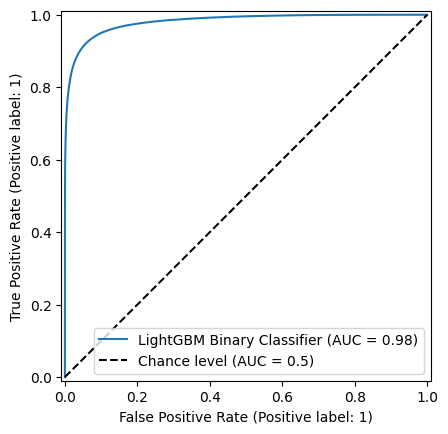

In [19]:
from sklearn.metrics import RocCurveDisplay

# display ROC curve
display = RocCurveDisplay.from_predictions(
    y_test_binary, y_pred_probs, name="LightGBM Binary Classifier", plot_chance_level=True, despine=False

)

In [23]:
X_test_transformed = clf_pipeline.preprocessor.transform(X_test)

DROPPED FEATURES:
[]


In [ ]:
from sklearn.metrics import RocCurveDisplay

# display ROC curve
display = RocCurveDisplay.from_estimator(
    clf_model, X_test_transformed, y_test_binary, name="LightGBM Binary Classifier", plot_chance_level=True, despine=False

)

Balanced Accuracy: 0.8931896484228498
Precision: 0.9398344600590522
Recall: 0.7970099016222971
F1: 0.8625497909643282
Support: None


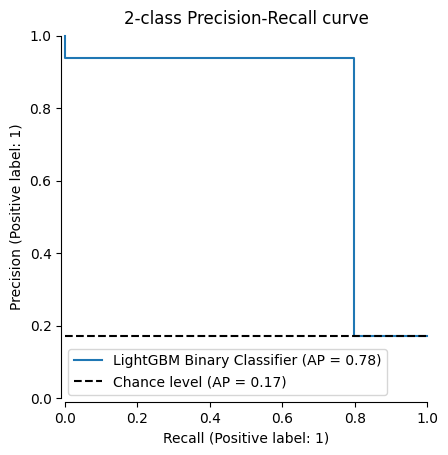

In [10]:
from sklearn.metrics import precision_recall_fscore_support, PrecisionRecallDisplay, balanced_accuracy_score

bACC = balanced_accuracy_score(y_test_binary, y_pred_binary)
print(f"Balanced Accuracy: {bACC}")

precision_recall_f1_support = precision_recall_fscore_support(y_test_binary, y_pred_binary, average='binary')
# print precision_recall_f1_support <- i see, this is only different from precision and recall
# if multiclass/averaging is different than binary
print(f"Precision: {precision_recall_f1_support[0]}")
print(f"Recall: {precision_recall_f1_support[1]}")
print(f"F1: {precision_recall_f1_support[2]}")
print(f"Support: {precision_recall_f1_support[3]}")

# display P-R Curve
display = PrecisionRecallDisplay.from_predictions(
    y_test_binary, y_pred_binary, name="LightGBM Binary Classifier", plot_chance_level=True, despine=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

### Evaluate Decision Thresholds

In [18]:
decision_thresholds = np.linspace(0, 1, 11)

for threshold in decision_thresholds:
    y_pred_binary_custom = (y_pred_probs > threshold).astype(int)
    bACC = balanced_accuracy_score(y_test_binary, y_pred_binary_custom)
    precision = precision_score(y_test_binary, y_pred_binary_custom, zero_division=True)
    recall = recall_score(y_test_binary, y_pred_binary_custom, zero_division=True)
    print(f"Threshold: {threshold:.2f} | Balanced Accuracy: {bACC:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")



Threshold: 0.00 | Balanced Accuracy: 0.5000 | Precision: 0.1724 | Recall: 1.0000
Threshold: 0.10 | Balanced Accuracy: 0.9276 | Precision: 0.6895 | Recall: 0.9438
Threshold: 0.20 | Balanced Accuracy: 0.9298 | Precision: 0.8134 | Recall: 0.9028
Threshold: 0.30 | Balanced Accuracy: 0.9207 | Precision: 0.8754 | Recall: 0.8671
Threshold: 0.40 | Balanced Accuracy: 0.9078 | Precision: 0.9134 | Recall: 0.8321
Threshold: 0.50 | Balanced Accuracy: 0.8932 | Precision: 0.9398 | Recall: 0.7970
Threshold: 0.60 | Balanced Accuracy: 0.8763 | Precision: 0.9588 | Recall: 0.7594
Threshold: 0.70 | Balanced Accuracy: 0.8567 | Precision: 0.9728 | Recall: 0.7175
Threshold: 0.80 | Balanced Accuracy: 0.8325 | Precision: 0.9840 | Recall: 0.6673
Threshold: 0.90 | Balanced Accuracy: 0.7989 | Precision: 0.9931 | Recall: 0.5987
Threshold: 1.00 | Balanced Accuracy: 0.5000 | Precision: 1.0000 | Recall: 0.0000


### Feature Importance

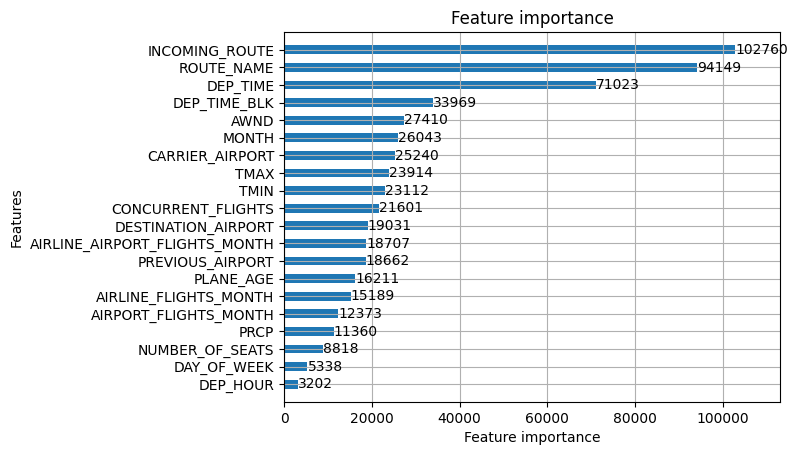

In [ ]:
lightgbm.plot_importance(clf_model, max_num_features=20, height=0.5, importance_type='split')
plt.show()

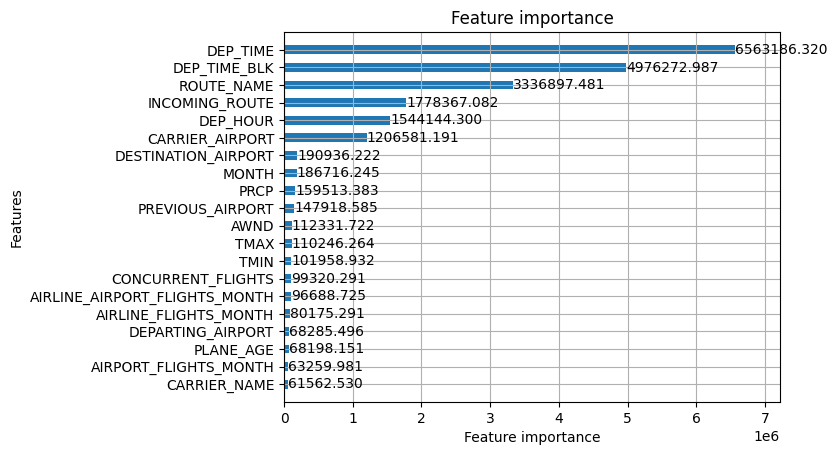

In [ ]:
lightgbm.plot_importance(clf_model, max_num_features=20, height=0.5, importance_type='gain')
plt.show()

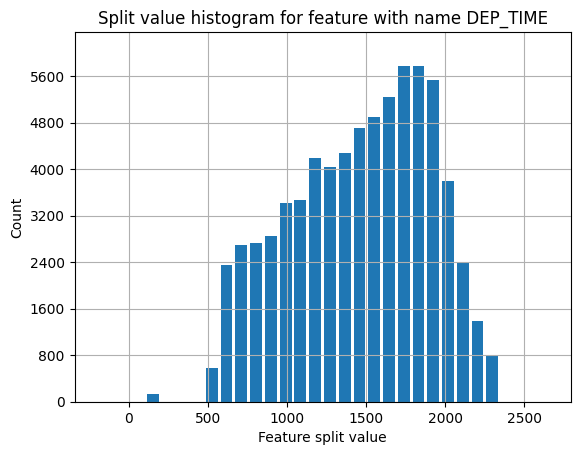

In [ ]:
lightgbm.plot_split_value_histogram(clf_model, feature='DEP_TIME', bins=24)
plt.show()

### Training Curves

binary_logloss


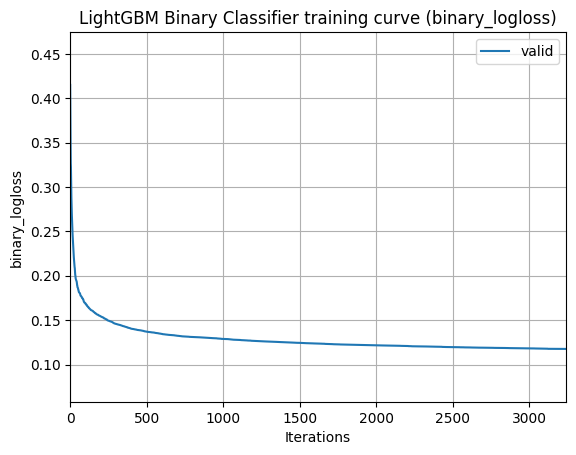

auc


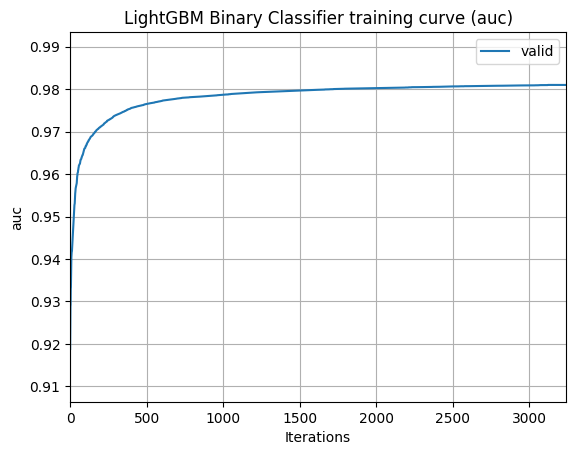

average_precision


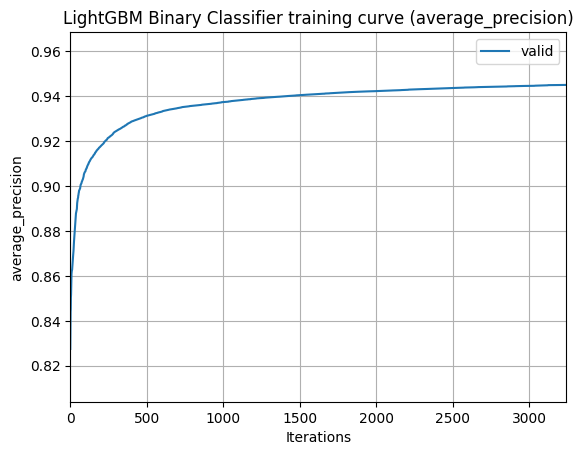

In [ ]:
for metric in clf_model.evals_result_['valid'].keys():
  print(metric)
  lightgbm.plot_metric(clf_model, metric=metric)
  plt.title(f'LightGBM Binary Classifier training curve ({metric})')
  plt.show()

### Decision Tree

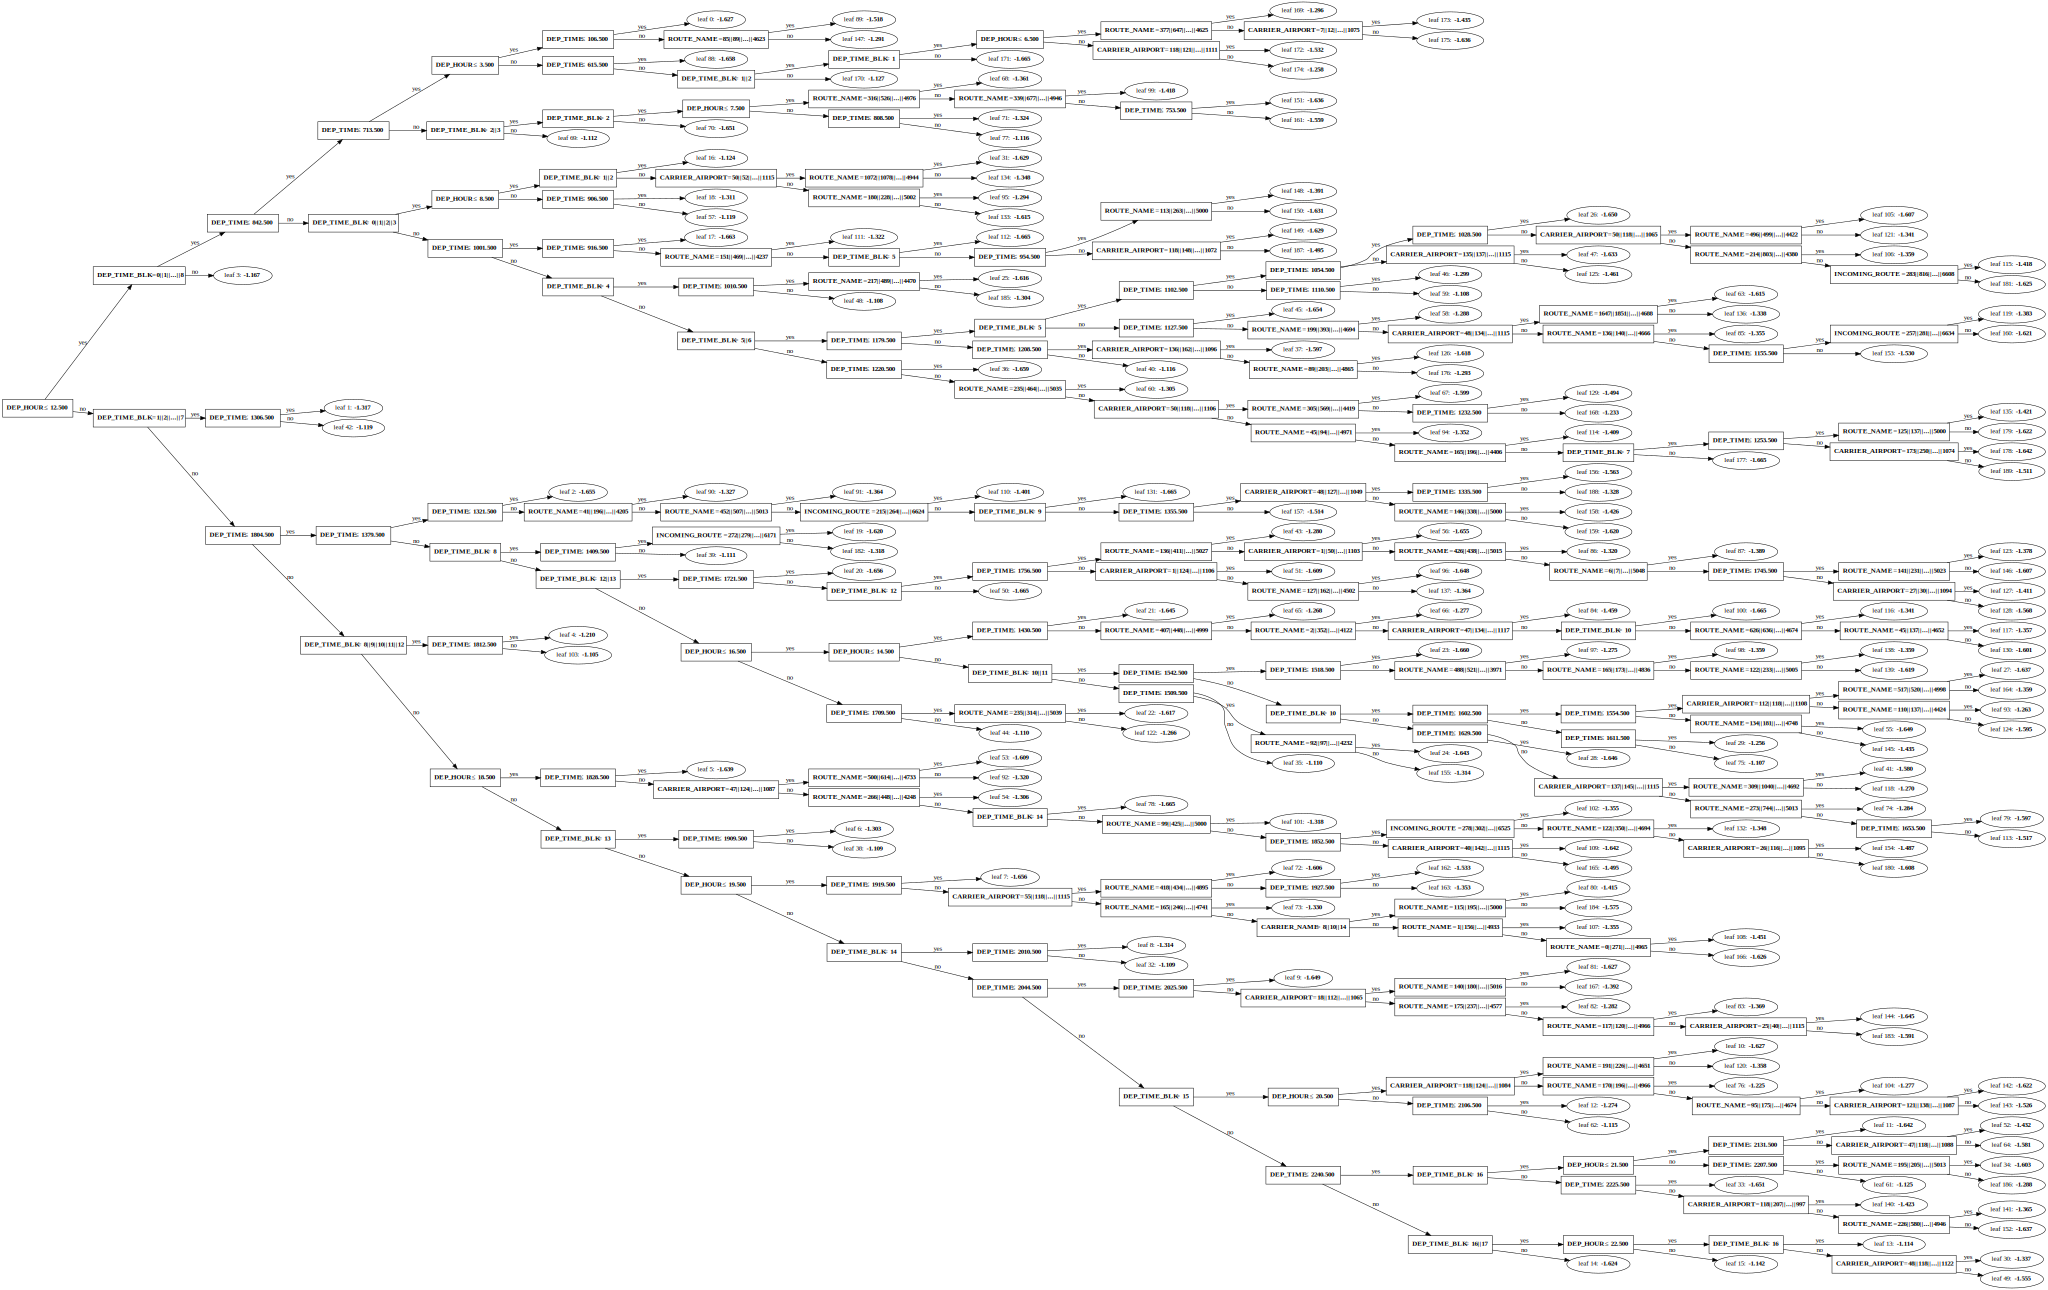

In [ ]:
from IPython.display import HTML
from IPython.display import display

graph = lightgbm.create_tree_digraph(clf_model, max_category_values=5)
HTML(graph._repr_image_svg_xml())
display(graph)

## Reconstruct Classifier Confusion Matrix

In [ ]:
# 2. Create an Analysis DataFrame
analysis_df = X_test.copy() # Start with features
analysis_df['Actual'] = y_test_binary
analysis_df['Predicted (Hard)'] = y_pred_binary
analysis_df['Predicted (Prob)'] = y_pred_probs

# 3. Tag Error Types
conditions = [
    (analysis_df['Actual'] == 1) & (analysis_df['Predicted (Hard)'] == 1), # TP
    (analysis_df['Actual'] == 0) & (analysis_df['Predicted (Hard)'] == 0), # TN
    (analysis_df['Actual'] == 0) & (analysis_df['Predicted (Hard)'] == 1), # FP
    (analysis_df['Actual'] == 1) & (analysis_df['Predicted (Hard)'] == 0)  # FN
]
choices = ['TP', 'TN', 'FP', 'FN']
analysis_df['Error_Type'] = np.select(conditions, choices, default='Unknown')

print(analysis_df['Error_Type'].value_counts())

Error_Type
TN    1041152
TP     174750
FN      44507
FP      11187
Name: count, dtype: int64


/tmp/ipython-input-1786868422.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Error_Type', y=feature, data=subset_df, palette="Set2")
/tmp/ipython-input-1786868422.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Error_Type', y=feature, data=subset_df, palette="Set2")


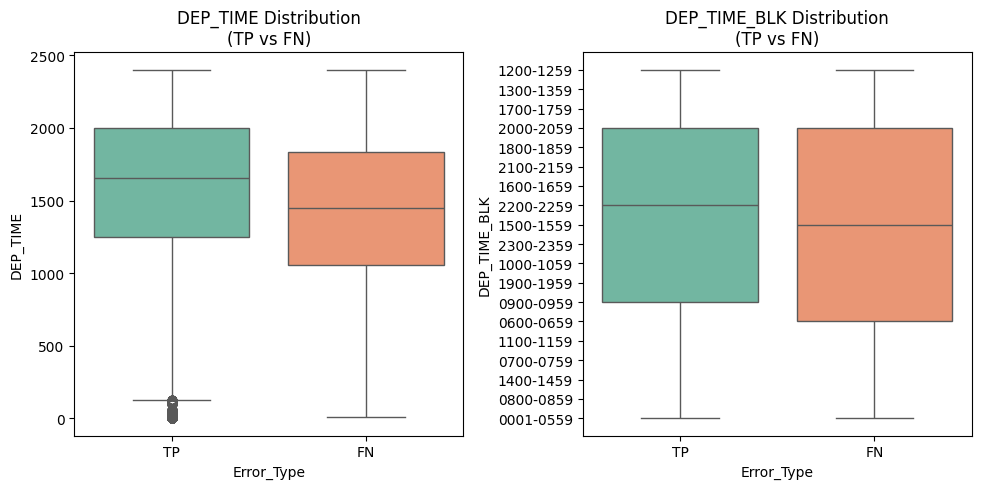

In [ ]:
# Select top 3-4 most important features to visualize
# (Replace these with your actual feature names)
features_to_inspect = ['DEP_TIME', 'DEP_TIME_BLK']

# Filter only for the Positive Class (Actual = 1)
# We want to see the difference between the ones we caught (TP) and missed (FN)
subset_df = analysis_df[analysis_df['Actual'] == 1]

plt.figure(figsize=(15, 5))
for i, feature in enumerate(features_to_inspect):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Error_Type', y=feature, data=subset_df, palette="Set2")
    plt.title(f'{feature} Distribution\n(TP vs FN)')
plt.tight_layout()
plt.show()

## Analyzing if the probability threshold is good

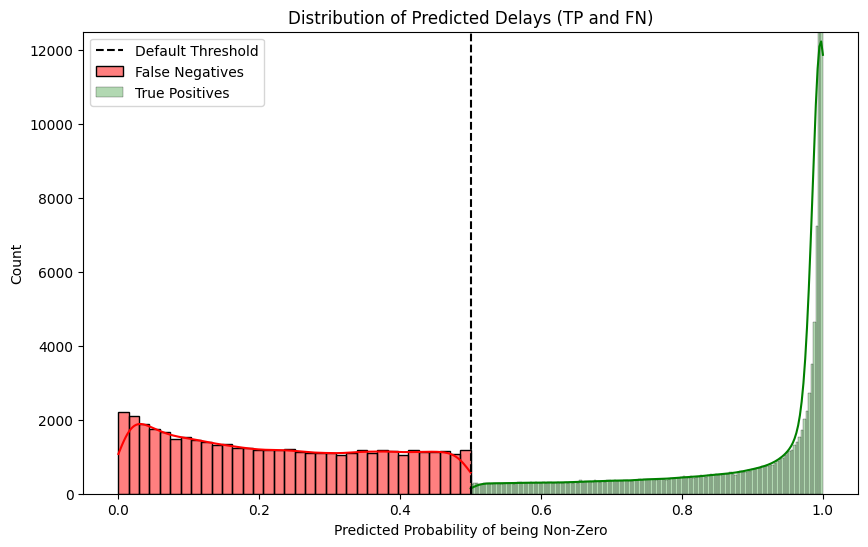

In [ ]:
# Plot the distribution of predicted probabilities for the Error groups
plt.figure(figsize=(10, 6))

# Histogram for False Negatives
sns.histplot(
    data=analysis_df[analysis_df['Error_Type'] == 'FN'],
    x='Predicted (Prob)',
    color='red',
    label='False Negatives',
    kde=True,
    alpha=0.5
)

# Histogram for True Positives (for context)
sns.histplot(
    data=analysis_df[analysis_df['Error_Type'] == 'TP'],
    x='Predicted (Prob)',
    color='green',
    label='True Positives',
    kde=True,
    alpha=0.3
)

plt.axvline(0.5, color='black', linestyle='--', label='Default Threshold')
plt.title("Distribution of Predicted Delays (TP and FN)")
plt.xlabel("Predicted Probability of being Non-Zero")
plt.ylim((None, 12500))
plt.legend()
plt.show()

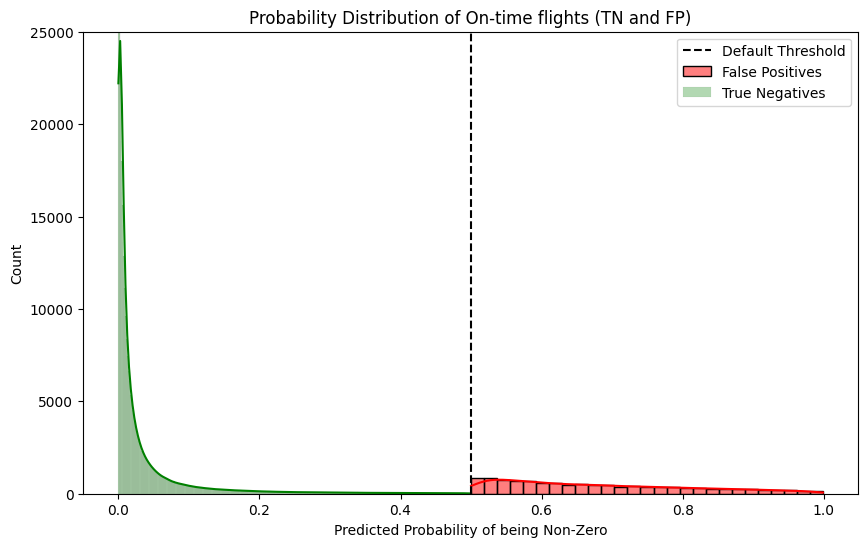

In [ ]:
# Plot the distribution of predicted probabilities for the Error groups
plt.figure(figsize=(10, 6))

# Histogram for False Positives
sns.histplot(
    data=analysis_df[analysis_df['Error_Type'] == 'FP'],
    x='Predicted (Prob)',
    color='red',
    label='False Positives',
    kde=True,
    alpha=0.5
)

# Histogram for True Negatives (for context)
sns.histplot(
    data=analysis_df[analysis_df['Error_Type'] == 'TN'],
    x='Predicted (Prob)',
    color='green',
    label='True Negatives',
    kde=True,
    alpha=0.3
)

plt.axvline(0.5, color='black', linestyle='--', label='Default Threshold')
plt.title("Probability Distribution of On-time flights (TN and FP)")
plt.xlabel("Predicted Probability of being Non-Zero")
plt.ylim((None, 25000))
plt.legend()
plt.show()

## What's Causing False Negatives? (Thinks there is not a delay when there is one)


In [ ]:
# 1. Reuse your positive_cases dataframe (TP and FN only)
positive_cases = analysis_df[analysis_df['Actual'] == 1].copy()

# 2. Calculate Means
feature_means = positive_cases.groupby('Error_Type').mean(numeric_only=True)

# 3. Calculate ABSOLUTE Difference (not percentage)
# This shows us the real unit difference (e.g., "Missed cases have 2 inches less snow on average")
diff_df = (feature_means.loc['FN'] - feature_means.loc['TP']).to_frame(name='Abs_Diff')

# 4. Add "Standard Deviation" context
# A difference of 0.1 is huge if the range is 0-1, but tiny if the range is 0-1000.
# We normalize the difference by the standard deviation of the feature.
std_devs = positive_cases.std(numeric_only=True)
diff_df['Normalized_Diff'] = diff_df['Abs_Diff'] / std_devs

# 5. Add Feature Importance (context check)
# (Optional: Add importance if you have it in a dict or series)
# diff_df['Importance'] = ...

# 6. Sort by the biggest Normalized Difference
# This finds features where the distributions are most separated
print("Top Differences (Normalized by Standard Deviation):")
print(diff_df['Normalized_Diff'].abs().sort_values(ascending=False).head(10))

# 7. Check SNOW specifically
print("\n--- SNOW Stats ---")
print(feature_means[['SNOW']])

Top Differences (Normalized by Standard Deviation):
Predicted (Hard)            2.486164
Predicted (Prob)            2.247735
DEP_HOUR                    0.339928
DEP_TIME                    0.325243
AIRLINE_FLIGHTS_MONTH       0.195908
AVG_MONTHLY_PASS_AIRLINE    0.188378
WT03                        0.151772
SEGMENT_NUMBER              0.149612
IS_HEAVY_RAIN               0.143121
NUMBER_OF_SEATS             0.115324
Name: Normalized_Diff, dtype: float64

--- SNOW Stats ---
                SNOW
Error_Type          
FN          0.039895
TP          0.064887


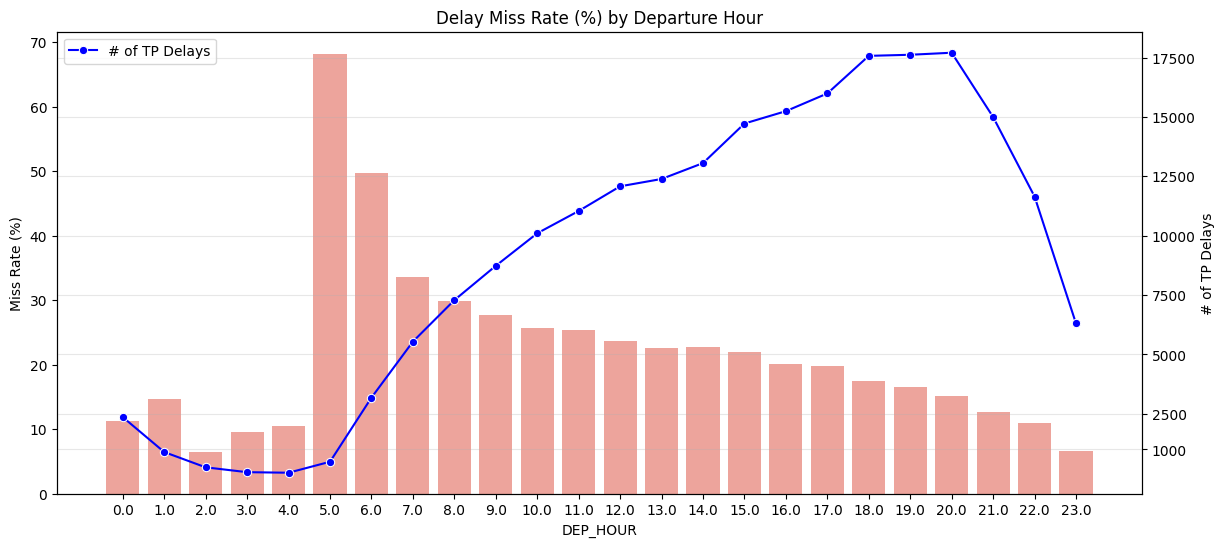

In [ ]:
# 1. Reuse analysis_df
# Ensure 'DEP_HOUR' is an integer/numeric column
# Group by Hour to see total volume vs error volume
hourly_stats = analysis_df.groupby('DEP_HOUR').agg(
    Total_Flights=('Actual', 'count'),
    Actual_Positives=('Actual', 'sum'),
    False_Negatives=('Error_Type', lambda x: (x == 'FN').sum())
).reset_index()

# 2. Calculate "Miss Rate" (FN / Actual Positives)
# Of all the delays that ACTUALLY happened at 5:00 AM, what % did we miss?
hourly_stats['Miss Rate (%)'] = (hourly_stats['False_Negatives'] / hourly_stats['Actual_Positives']) * 100

# 3. Visualization
plt.figure(figsize=(14, 6))

# Bar plot for Miss Rate
sns.barplot(data=hourly_stats, x='DEP_HOUR', y='Miss Rate (%)', color='salmon', alpha=0.8)

# Overlay a line for Volume (to check if it's just low data)
ax2 = plt.twinx()
sns.lineplot(data=hourly_stats, x='DEP_HOUR', y='Actual_Positives', ax=ax2, color='blue', marker='o', label='# of TP Delays')

plt.title("Delay Miss Rate (%) by Departure Hour")
ax2.set_ylabel("# of TP Delays")
ax2.set_yticks(np.concatenate(([1000], np.arange(2500, 17501, 2500))))
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
import pandas as pd

# 1. Check raw counts in the Test set first (since we have analysis_df)
# We want to see how many times WT11=1 actually results in a Positive vs Negative
print("--- WT11 Behavior in Test Set ---")
print(pd.crosstab(analysis_df['WT11'], analysis_df['Actual'], margins=True))

# 2. Check the "Kill Rate"
# Of all times WT11 appeared, what % were actually Zero?
subset = analysis_df[analysis_df['WT11'] == 1]
zero_rate = (subset['Actual'] == 0).mean()
print(f"\nWhen WT11 is present, the Actual value is ZERO {zero_rate:.1%} of the time.")

# 3. Check Importance (if tree model)
# If you have a tree model, checking feature importance might confirm it's using this heavily
# (Skip this if you are using a linear/logistic regression for the hurdle)
try:
    # Assuming the first step of your hurdle pipeline is the classifier
    # Adjust 'classifier' to whatever your named step is
    importances = clf_model.feature_importances_
    feature_names = clf_model.feature_names_in_

    # Create a small df to view it
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    print("\n--- Model Reliance on WT11 ---")
    print(imp_df[imp_df['Feature'] == 'WT11'])
except:
    print("\n(Could not retrieve feature importances directly from pipeline)")

--- WT11 Behavior in Test Set ---
Actual        0       1      All
WT11                            
0.0     1052323  219255  1271578
1.0          16       2       18
All     1052339  219257  1271596

When WT11 is present, the Actual value is ZERO 88.9% of the time.

--- Model Reliance on WT11 ---
   Feature  Importance
40    WT11           0


In [ ]:
# Calculate mean feature values for TP and FN
comparison = analysis_df.groupby('Error_Type')[['DEP_TIME']].mean().transpose()
comparison = comparison[['TP', 'FN']]

# Calculate the % difference: How different are the Missed cases from the Caught cases?
comparison['% Difference'] = ((comparison['FN'] - comparison['TP']) / comparison['TP']) * 100

print("Feature value differences between Missed (FN) and Caught (TP) cases:")
print(comparison)

Feature value differences between Missed (FN) and Caught (TP) cases:
Error_Type           TP           FN  % Difference
DEP_TIME    1598.159279  1441.059766     -9.830029


# Evaluate Regressor Results

In [22]:
print(f"Loading: {REGRESSOR_PATH}")
reg_pipeline = joblib.load(REGRESSOR_PATH)
reg_model = reg_pipeline.model
feature_names = reg_model.feature_name_
importances = reg_model.feature_importances_

Loading: /content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/Gamma Regression/LGBM_RegHurdle_Gamma_added_delay_20251203_044351.joblib


In [ ]:
# load model performance metrics from json file
import json
results_path = '/content/drive/MyDrive/CIS 5200 Final Project/models/lightGBM/Gamma Regression/LGBM_RegHurdle_Gamma_added_delay_20251203_041357_metrics.json'
# results_path = '/content/drive/My Drive/CIS 5200 Final Project/models/lightGBM/Tweedie Regression/LGBM_Reg_SingleStage_Tweedie_added_delay_20251204_074723_metrics.json'
with open(results_path, 'r') as f:
    results = json.load(f)


pprint(f'RMSE: {results['rmse']}')
pprint(f'MAE: {results['mae']}')
pprint(f'R2: {results['r2']}')
pprint(f'MAPE: {results['mape']}')
pprint(f'Mean Gamma Deviance: {results['gamma_deviance']}')
pprint(f'Mean Tweedie Deviance: {results['tweedie_deviance']}')
# pprint(results)

'RMSE: 11.452075547858714'
'MAE: 8.191138996342481'
'R2: 0.8380999062527136'
'MAPE: 0.7667028310959159'
'Mean Gamma Deviance: 0.34611874334924464'
'Mean Tweedie Deviance: 1.148813369275834'


In [ ]:
results['parameters']

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7,
 'importance_type': 'split',
 'learning_rate': 0.19,
 'max_depth': 13,
 'min_child_samples': 19,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 4900,
 'n_jobs': -1,
 'num_leaves': 211,
 'objective': 'gamma',
 'random_state': None,
 'reg_alpha': 2.0631737727940105e-06,
 'reg_lambda': 0.00020147986163818538,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 6,
 'verbose': 1,
 'stopping_rounds': 100,
 'metric': ['gamma', 'mae', 'rmse', 'r2']}

In [ ]:
reg_model.best_iteration_ # early stopping kicked in.

4142

### Feature Importance

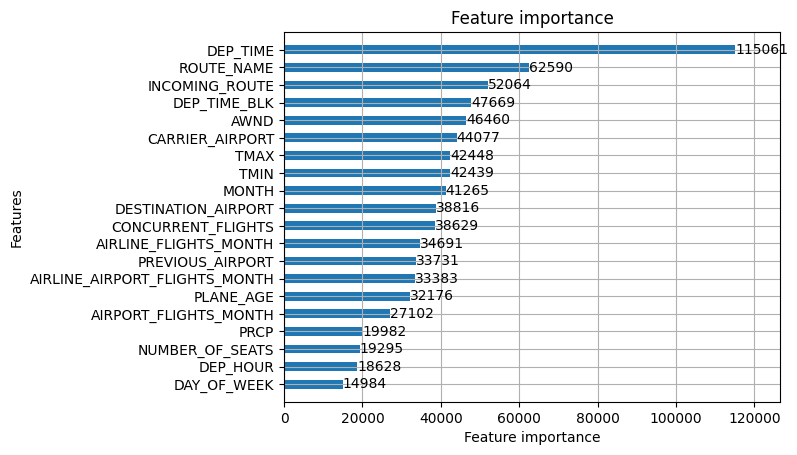

In [ ]:
lightgbm.plot_importance(reg_model, max_num_features=20, height=0.5, importance_type='split')
plt.show()

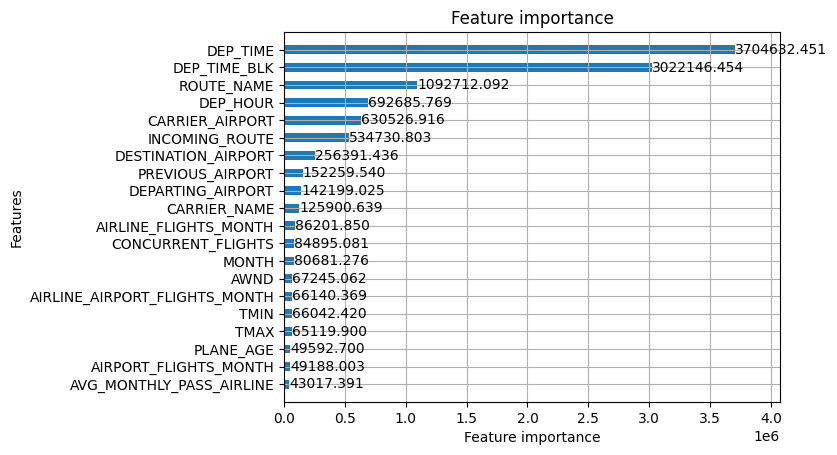

In [ ]:
lightgbm.plot_importance(reg_model, max_num_features=20, height=0.5, importance_type='gain')
plt.show()

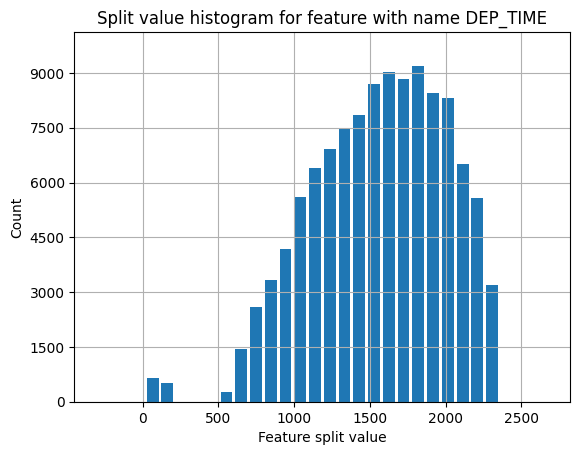

In [ ]:
lightgbm.plot_split_value_histogram(reg_model, feature='DEP_TIME', bins=24)
plt.show()

### Training Curves

odict_keys(['gamma', 'l1', 'rmse'])

In [ ]:
reg_model.evals_result_

['gamma', 'mae', 'rmse', 'r2']

gamma


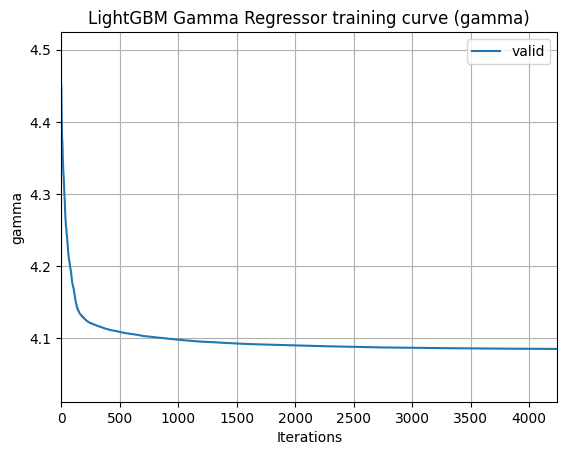

l1


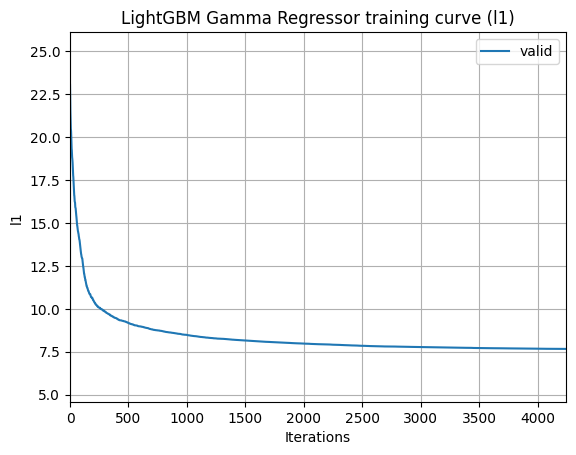

rmse


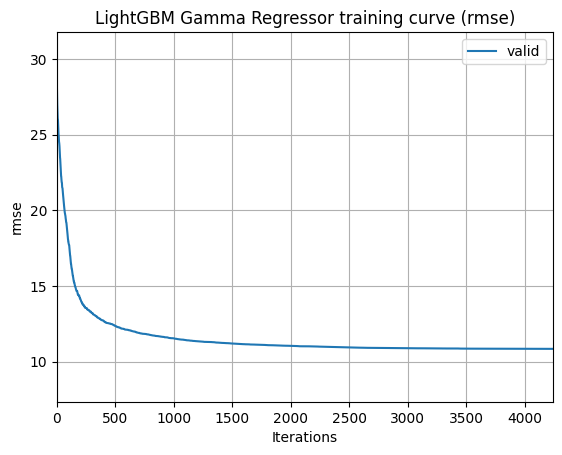

In [ ]:
for metric in reg_model.evals_result_['valid'].keys():
  print(metric)
  lightgbm.plot_metric(reg_model, metric=metric)
  plt.title(f'LightGBM Gamma Regressor training curve ({metric})')
  plt.show()

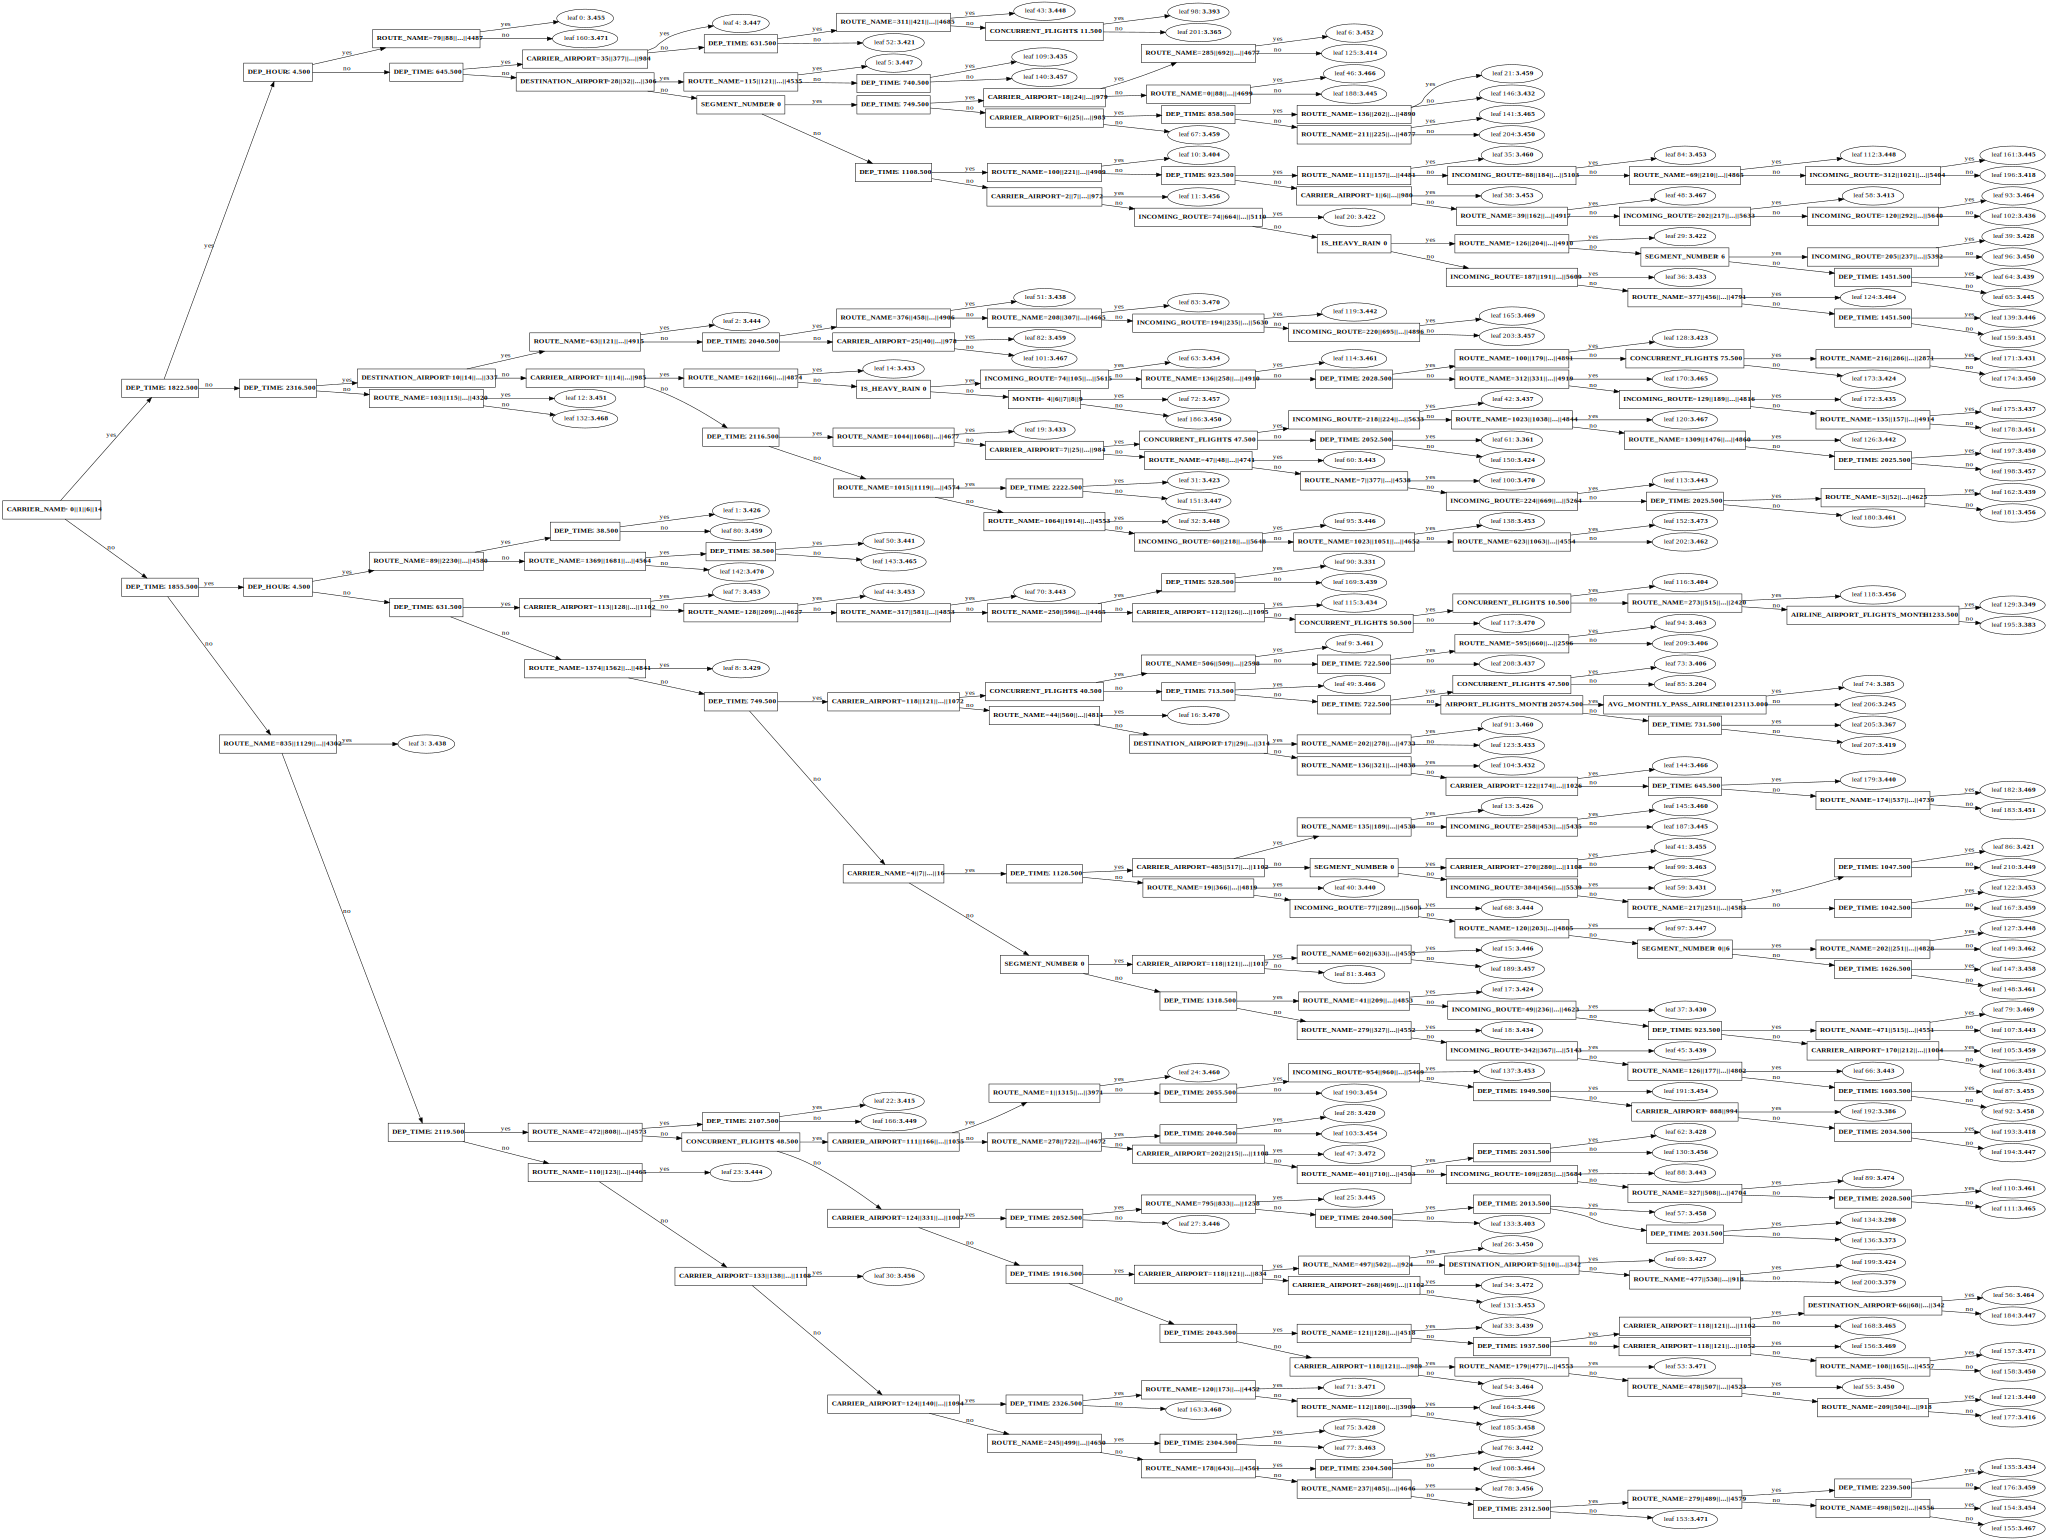

In [ ]:
from IPython.display import HTML
from IPython.display import display

reg_model_graph = lightgbm.create_tree_digraph(reg_model, max_category_values=5)
HTML(reg_model_graph._repr_image_svg_xml())
display(reg_model_graph)

## Residual Analysis

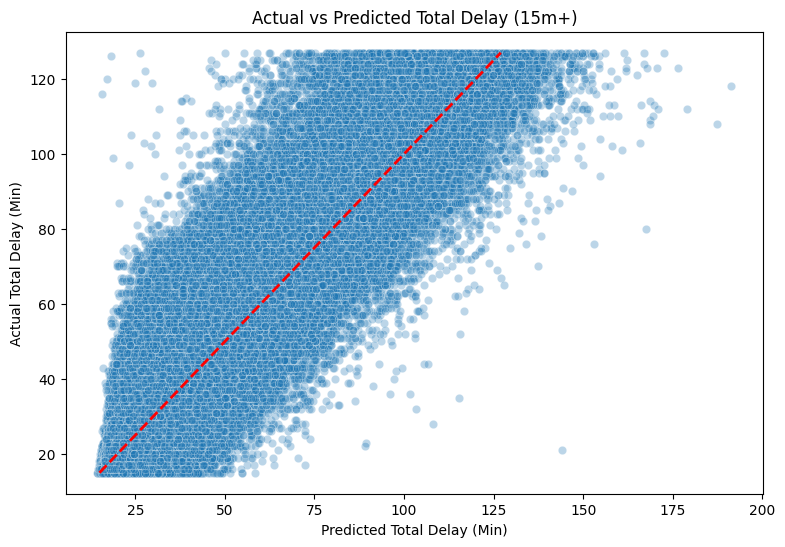

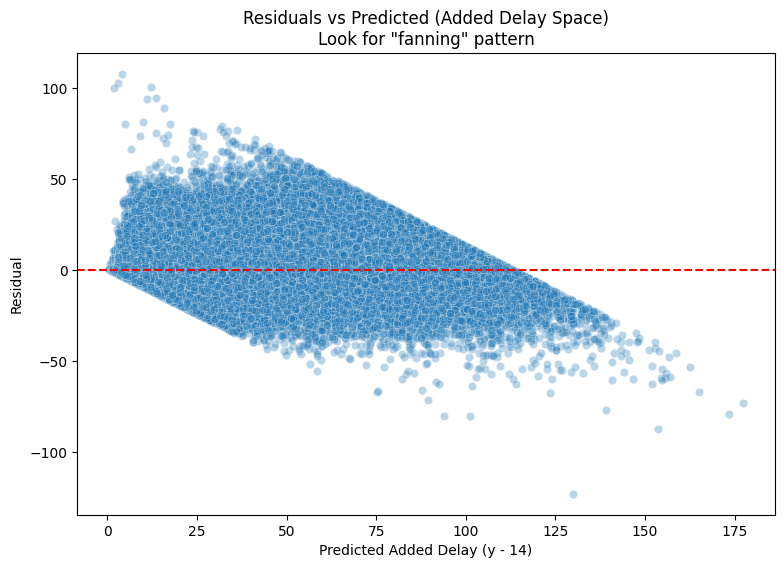

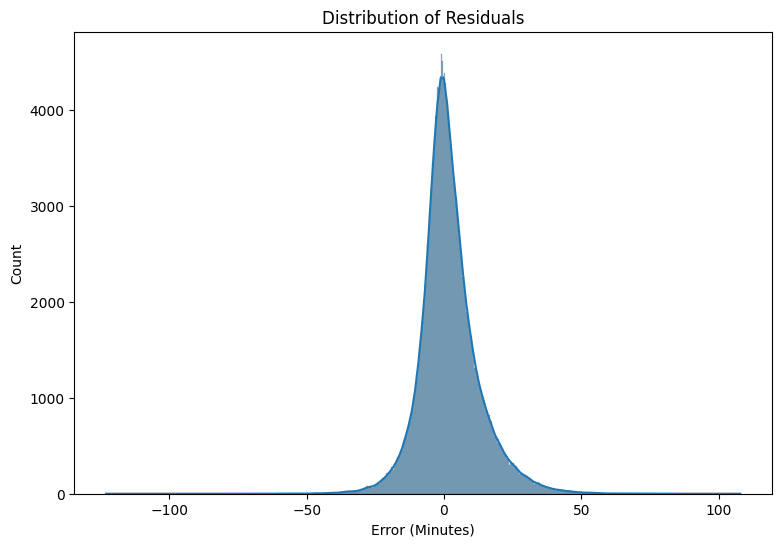

/tmp/ipython-input-1967186858.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bin_metrics = df.dropna(subset=['delay_bin']).groupby('delay_bin', observed=False).apply(


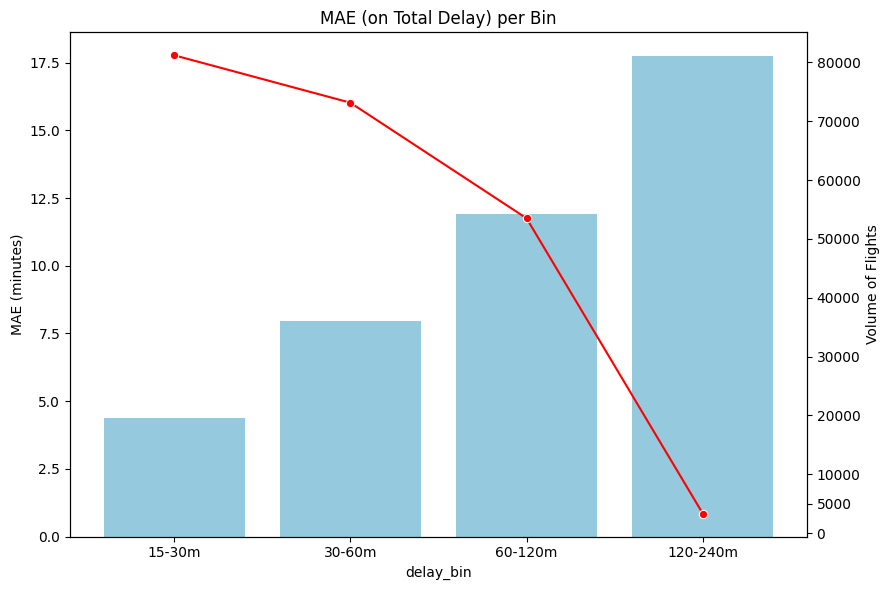


Error Metrics by Real Delay Magnitude:
  delay_bin  MAPE_Total  SMAPE_Total        MAE    Count
0    15-30m   20.943414    18.079536   4.385880  81223.0
1    30-60m   18.231239    19.779224   7.942847  73160.0
2   60-120m   14.370156    15.862947  11.917274  53502.0
3  120-240m   14.298703    16.066072  17.734321   3296.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
# If you don't have permetrics installed, we can define SMAPE manually to remove the dependency
# from permetrics.regression import RegressionMetric

# --- SETUP ---
OFFSET = 14 # The hurdle threshold

# 1. Filter data to only include actual positive delays
# We assume 'y_test_df' has the raw target (Added Delay)
positive_delay_mask = (y_test_df[CLS_TARGET] == 1)

# Extract Added Delays (The Regressor's native space)
y_true_added = y_test_df.loc[positive_delay_mask, REG_TARGET].reset_index(drop=True)
y_pred_added = pd.Series(y_pred_mags[positive_delay_mask], name='y_pred_filtered').reset_index(drop=True)

# 2. Restore "Total Delay" (The Real World space)
# This is crucial for meaningful MAPE/SMAPE and binning
y_true_total = y_true_added + OFFSET
y_pred_total = y_pred_added + OFFSET

# Create the DataFrame
df = pd.DataFrame({
    'y_true_added': y_true_added,
    'y_pred_added': y_pred_added,
    'y_true_total': y_true_total,
    'y_pred_total': y_pred_total
})

if df.empty:
    raise ValueError("No positive delays found.")

# --- METRIC HELPER ---
# Manual SMAPE function to ensure it runs per-row/per-group correctly
# Formula: 100/n * sum( |y - y_hat| / ( (|y| + |y_hat|) / 2 ) )
def calculate_smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    # Handle division by zero if both are 0 (unlikely here but good practice)
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 1, figsize=(9, 6))

# Plot A: Actual vs Predicted (Total Delay Space)
# We plot in Total Space because that's what we intuitively understand
sns.scatterplot(x='y_pred_total', y='y_true_total', data=df, alpha=0.3)
axes.plot([df['y_true_total'].min(), df['y_true_total'].max()],
               [df['y_true_total'].min(), df['y_true_total'].max()], 'r--', lw=2)
axes.set_title('Actual vs Predicted Total Delay (15m+)')
axes.set_xlabel('Predicted Total Delay (Min)')
axes.set_ylabel('Actual Total Delay (Min)')
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(9, 6))
# Plot B: Residuals vs Predicted (Gamma Check)
# For residuals, we can look at Added Space to see how the Regressor "feels"
df['residuals_added'] = df['y_true_added'] - df['y_pred_added']
sns.scatterplot(x='y_pred_added', y='residuals_added', data=df, alpha=0.3)
axes.axhline(0, color='r', linestyle='--')
axes.set_title('Residuals vs Predicted (Added Delay Space)\nLook for "fanning" pattern')
axes.set_xlabel('Predicted Added Delay (y - 14)')
axes.set_ylabel('Residual')
plt.show()


fig, axes = plt.subplots(1, 1, figsize=(9, 6))
# Plot C: Error Distribution
sns.histplot(df['residuals_added'], kde=True)
axes.set_title('Distribution of Residuals')
axes.set_xlabel('Error (Minutes)')
plt.show()

# Plot D: Error Analysis by Magnitude (Real World Bins)
# We bin on y_true_total so the labels "15-30" match reality
# Bins: 15-30, 30-60, 60-120, 120-240, 240+
bins = [15, 30, 60, 120, 240]
labels = ['15-30m', '30-60m', '60-120m', '120-240m']

df['delay_bin'] = pd.cut(df['y_true_total'], bins=bins, labels=labels)

# Groupby calculation
# Note: We calculate metrics on TOTAL delay to avoid skewing small delays
bin_metrics = df.dropna(subset=['delay_bin']).groupby('delay_bin', observed=False).apply(
    lambda x: pd.Series({
        'MAPE_Total': np.mean(np.abs((x['y_true_total'] - x['y_pred_total']) / x['y_true_total'])) * 100,
        'SMAPE_Total': calculate_smape(x['y_true_total'], x['y_pred_total']),
        'MAE': mean_absolute_error(x['y_true_total'], x['y_pred_total']),
        'Count': len(x)
    })
).reset_index()

fig, axes = plt.subplots(1, 1, figsize=(9, 6))
# Plot SMAPE
sns.barplot(x='delay_bin', y='MAE', data=bin_metrics, color='skyblue')
ax2 = axes.twinx()
sns.lineplot(x='delay_bin', y='Count', data=bin_metrics, ax=ax2, color='red', marker='o')
axes.set_title('MAE (on Total Delay) per Bin')
axes.set_ylabel('MAE (minutes)')
ax2.set_ylabel('Volume of Flights')
ax2.set_yticks(np.concatenate((np.arange(0, 10001, 5000), np.arange(20000, 80001, 10000))))
plt.tight_layout()
plt.show()

print("\nError Metrics by Real Delay Magnitude:")
print(bin_metrics)

In [ ]:
np.concatenate((np.arange(0, 10001, 5000), np.arange(20000, 80001, 10000)))

array([    0,  5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000,
       80000])

# Full Hurdle Model Analysis

## Calibration/Reliability

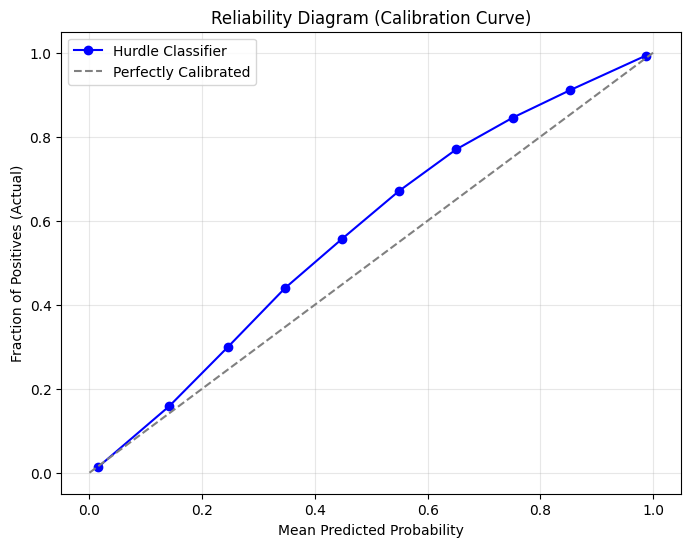

In [ ]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(y_true_binary, y_prob):
    # prob_true: The true fraction of positives in that bin
    # prob_pred: The mean predicted probability in that bin
    prob_true, prob_pred = calibration_curve(y_true_binary, y_prob, n_bins=10, strategy='uniform')

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(prob_pred, prob_true, marker='o', label='Hurdle Classifier', color='blue')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives (Actual)')
    ax.set_title('Reliability Diagram (Calibration Curve)')
    ax.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Usage:
plot_calibration_curve(y_test_df[CLS_TARGET], y_pred_probs)

## Lift

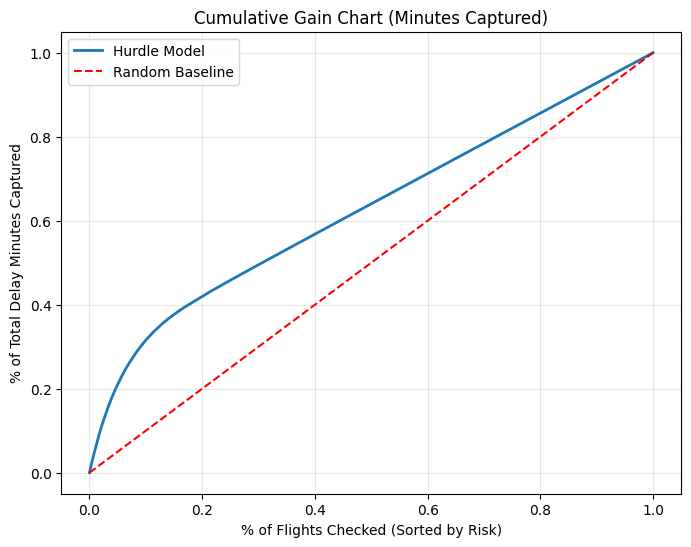

Top 10% of predicted risky flights contain 31.5% of all actual delay minutes.


In [ ]:
def plot_cumulative_gain_minutes(df):
    # 1. Sort by Predicted Expected Delay (High to Low)
    df_sorted = df.sort_values(by='y_pred_total', ascending=False).reset_index(drop=True)

    # 2. Calculate Cumulative Sum of Actual Delay Minutes
    df_sorted['cum_actual_delay'] = df_sorted['y_true_total'].cumsum()

    # 3. Normalize to percentages
    total_delay_minutes = df_sorted['y_true_total'].sum()
    df_sorted['cum_perc_delay'] = df_sorted['cum_actual_delay'] / total_delay_minutes
    df_sorted['perc_flights'] = (df_sorted.index + 1) / len(df_sorted)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(df_sorted['perc_flights'], df_sorted['cum_perc_delay'], label='Hurdle Model', lw=2)

    # Random Baseline (If we picked flights randomly)
    ax.plot([0, 1], [0, 1], 'r--', label='Random Baseline')

    ax.set_xlabel('% of Flights Checked (Sorted by Risk)')
    ax.set_ylabel('% of Total Delay Minutes Captured')
    ax.set_title('Cumulative Gain Chart (Minutes Captured)')
    ax.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Metric: "Lift at 10%"
    lift_10 = df_sorted.loc[int(len(df_sorted)*0.1), 'cum_perc_delay']
    print(f"Top 10% of predicted risky flights contain {lift_10:.1%} of all actual delay minutes.")

# Usage: Use the 'df' created in the previous extrapolated code
plot_cumulative_gain_minutes(df)

## Decoupled Error Analysis

/tmp/ipython-input-1869884627.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='confusion', y='y_pred_total', data=df, order=['TN', 'FN', 'FP', 'TP'], palette="Set2")


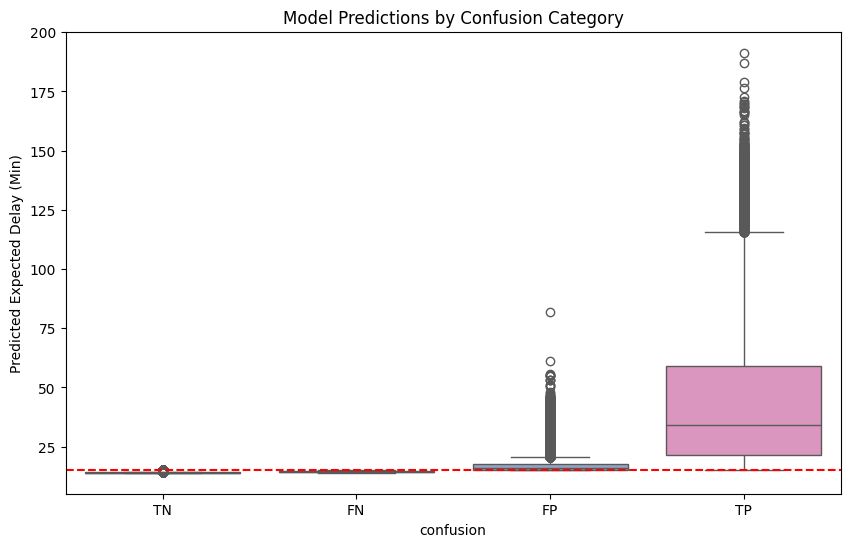

In [ ]:
def plot_decoupled_error(df, threshold=0.5):
    # Define Binary Decisions
    # Note: 'y_pred_total' > 15 roughly implies the model "thinks" there is a delay
    # But strictly, we should use the probability threshold
    # Assuming you have the probability column 'prob_delay':

    # For this example, let's proxy "Predicted Delay" as Expected Value > 15
    pred_delay = df['y_pred_total'] >= 15
    true_delay = df['y_true_total'] >= 15

    conditions = [
        (~pred_delay & ~true_delay), # TN
        (pred_delay & true_delay),   # TP
        (pred_delay & ~true_delay),  # FP (Ghost Delay)
        (~pred_delay & true_delay)   # FN (Missed Delay)
    ]
    choices = ['TN', 'TP', 'FP', 'FN']
    df['confusion'] = np.select(conditions, choices, default='Error')

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x='confusion', y='y_pred_total', data=df, order=['TN', 'FN', 'FP', 'TP'], palette="Set2")
    ax.axhline(15, color='r', linestyle='--', label='Hurdle (15m)')
    ax.set_title('Model Predictions by Confusion Category')
    ax.set_ylabel('Predicted Expected Delay (Min)')
    plt.show()

# Usage:
plot_decoupled_error(df)

## Residuals

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


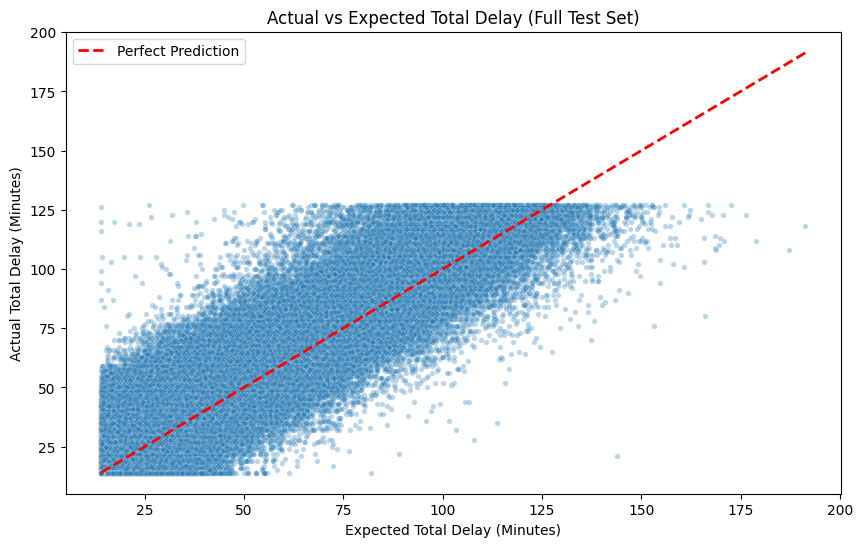

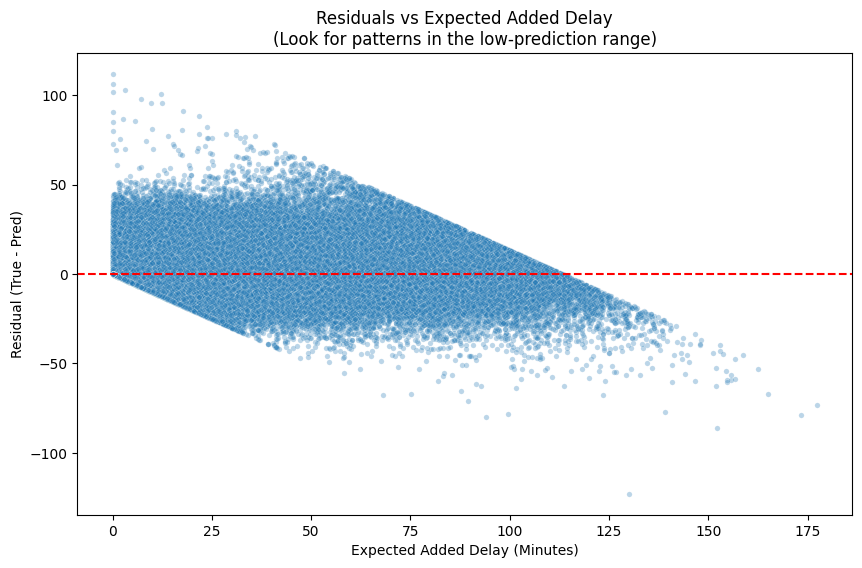

/tmp/ipython-input-2615746477.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bin_metrics = df.groupby('delay_bin', observed=False).apply(


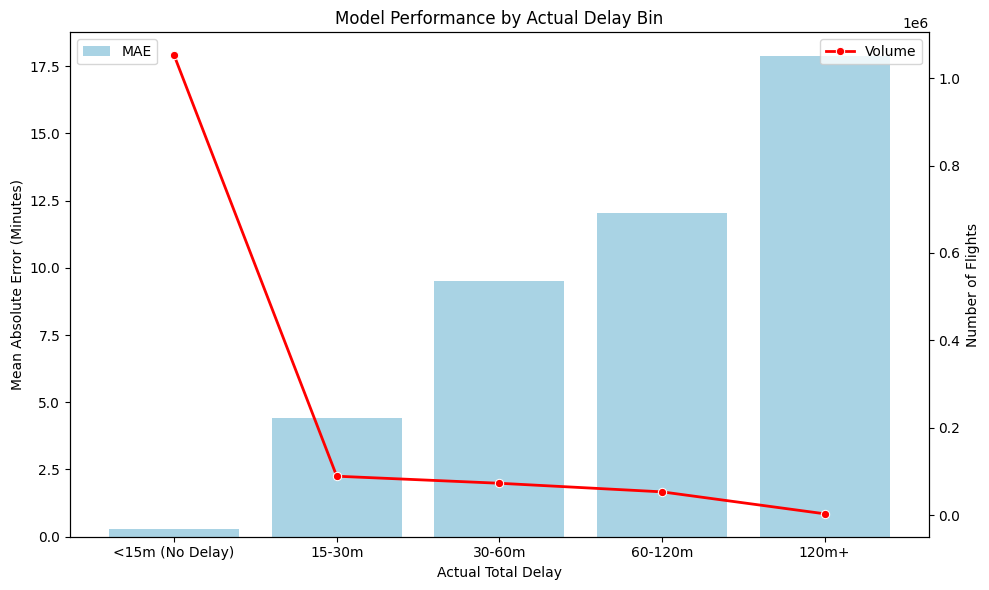


Detailed Error Metrics by Bin:
         delay_bin        MAE       RMSE       Bias      Count
0  <15m (No Delay)   0.299482   1.141888   0.299482  1052339.0
1           15-30m   4.433157   6.133373  -0.812565    89299.0
2           30-60m   9.514537  12.157601  -5.753888    73160.0
3          60-120m  12.046096  15.877535  -6.927032    53502.0
4            120m+  17.863982  22.707689 -14.544981     3296.0


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- SETUP ---
OFFSET = 14  # The hurdle threshold

# 1. Create DataFrame from Full Test Set
# We use the full 'y_test_reg' (which includes 0s) and 'y_pred_hurdle_reg' (prob * mag)
df = pd.DataFrame({
    'y_true_added': y_test_reg.reset_index(drop=True),
    'y_pred_added': pd.Series(y_pred_hurdle_reg).reset_index(drop=True)
})

# 2. Restore "Total Delay" for interpretation
# Note: For non-delayed flights (0 added), this sets Total to 14 minutes.
# This assumes the "Hurdle" implies anything <=14 is effectively 14 for this comparison.
df['y_true_total'] = df['y_true_added'] + OFFSET
df['y_pred_total'] = df['y_pred_added'] + OFFSET

# Calculate Residuals (Added space is usually cleaner for math)
df['residuals_added'] = df['y_true_added'] - df['y_pred_added']

# --- METRIC HELPER ---
def calculate_smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    # Fix division by zero cases
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

# --- VISUALIZATION ---

# Plot A: Actual vs Predicted (Full Distribution)
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.scatterplot(x='y_pred_total', y='y_true_total', data=df, alpha=0.3, s=15)

# Add identity line
min_val = min(df['y_true_total'].min(), df['y_pred_total'].min())
max_val = max(df['y_true_total'].max(), df['y_pred_total'].max())
axes.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

axes.set_title('Actual vs Expected Total Delay (Full Test Set)')
axes.set_xlabel('Expected Total Delay (Minutes)')
axes.set_ylabel('Actual Total Delay (Minutes)')
axes.legend()

#
# Note: You will likely see a horizontal line at y=14. These are flights that
# weren't delayed, but your model predicted a small positive expected value.
plt.show()

# Plot B: Residuals vs Predicted
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.scatterplot(x='y_pred_added', y='residuals_added', data=df, alpha=0.3, s=15)
axes.axhline(0, color='r', linestyle='--')
axes.set_title('Residuals vs Expected Added Delay\n(Look for patterns in the low-prediction range)')
axes.set_xlabel('Expected Added Delay (Minutes)')
axes.set_ylabel('Residual (True - Pred)')
plt.show()

# Plot C: Error Analysis by Magnitude (Updated Bins)
# We need a bin for "No Delay" (approx <= 14m)
# Bins: <14.1 (No Delay), 15-30, 30-60, 60-120, 120+
bins = [-np.inf, 14.1, 30, 60, 120, np.inf]
labels = ['<15m (No Delay)', '15-30m', '30-60m', '60-120m', '120m+']

df['delay_bin'] = pd.cut(df['y_true_total'], bins=bins, labels=labels)

# Groupby calculation
bin_metrics = df.groupby('delay_bin', observed=False).apply(
    lambda x: pd.Series({
        # MAE is robust here
        'MAE': mean_absolute_error(x['y_true_total'], x['y_pred_total']),
        # RMSE emphasizes large outliers
        'RMSE': np.sqrt(mean_squared_error(x['y_true_total'], x['y_pred_total'])),
        # Bias tells you if you generally over/under predict in that bin
        'Bias': np.mean(x['y_pred_total'] - x['y_true_total']),
        'Count': len(x)
    })
).reset_index()

fig, axes = plt.subplots(1, 1, figsize=(10, 6))
# Plot MAE Bar Chart
sns.barplot(x='delay_bin', y='MAE', data=bin_metrics, color='skyblue', alpha=0.8, label='MAE')

# Plot Volume on Secondary Axis
ax2 = axes.twinx()
sns.lineplot(x='delay_bin', y='Count', data=bin_metrics, ax=ax2, color='red', marker='o', lw=2, label='Volume')

axes.set_title('Model Performance by Actual Delay Bin')
axes.set_xlabel('Actual Total Delay')
axes.set_ylabel('Mean Absolute Error (Minutes)')
ax2.set_ylabel('Number of Flights')
plt.tight_layout()
plt.show()

print("\nDetailed Error Metrics by Bin:")
print(bin_metrics)

# Feature Importance (accounting for Collinear Featues)

## Target encode

In [ ]:
X_test.columns

Index(['MONTH', 'DAY_OF_WEEK', 'DEP_TIME', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'DEP_HOUR', 'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
       'CARRIER_NAME', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH',
       'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT',
       'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS',
       'GROUND_SERV_PER_PASS', 'PLANE_AGE', 'DEPARTING_AIRPORT',
       'PREVIOUS_AIRPORT', 'DESTINATION_AIRPORT', 'ROUTE_NAME',
       'INCOMING_ROUTE', 'CARRIER_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX',
       'TMIN', 'AWND', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07',
       'WT08', 'WT09', 'WT10', 'WT11', 'AWND_missing', 'TMIN_missing',
       'TMAX_missing', 'IS_HEAVY_RAIN', 'IS_SNOWY', 'IS_FREEZING',
       'IS_EXTREME_HEAT', 'SEASON'],
      dtype='object')

In [19]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# --- 1. Identify your column types ---
# List your categorical string columns
# Updated based on your engineered feature set
CATEGORICAL_COLS = [
    # Core IDs
    'CARRIER_NAME',
    'DEPARTING_AIRPORT',
    'PREVIOUS_AIRPORT',
    'DESTINATION_AIRPORT',

    # Engineered Routes
    'ROUTE_NAME',      # Origin -> Dest
    'INCOMING_ROUTE',  # Prev -> Origin
    'CARRIER_AIRPORT', # Hub Effect

    # Time
    'DEP_TIME_BLK',
    'MONTH',
    'DAY_OF_WEEK',
    'SEASON',

    # Groups
    'DISTANCE_GROUP',
    'SEGMENT_NUMBER',

    # Weather Flags (Treating binary flags as categories is safe/good for LGBM)
    'IS_HEAVY_RAIN', 'IS_SNOWY',
    'IS_FREEZING', 'IS_EXTREME_HEAT',
    'AWND_missing', 'TMIN_missing', 'TMAX_missing',
]
# List your numeric columns
NUMERIC_COLS = [c for c in X_test.columns if c not in CATEGORICAL_COLS]

# --- 2. Target Encode the Categoricals ---
# We create a copy so we don't mess up the original data
X_encoded = X_test.copy()

# IMPORTANT: In a real pipeline, calculate means on TRAIN data and map to TEST.
# For this analysis, we will map using the current data for simplicity.
# y_test_total is the 'Total Delay' we calculated in the previous step.

for col in CATEGORICAL_COLS:
    # 1. Calculate average delay for each category string
    # We use the actual target (y_true) to determine the 'weight' of the category
    mapping = df.groupby(X_encoded[col])['y_true_total'].mean()

    # 2. Map the means to the dataframe
    X_encoded[col] = X_encoded[col].map(mapping)

    # 3. Fill NaNs (if a category in test wasn't in the grouping) with global mean
    X_encoded[col] = X_encoded[col].fillna(df['y_true_total'].mean())



NameError: name 'df' is not defined

## Visualize Dendrograms and Heatmap

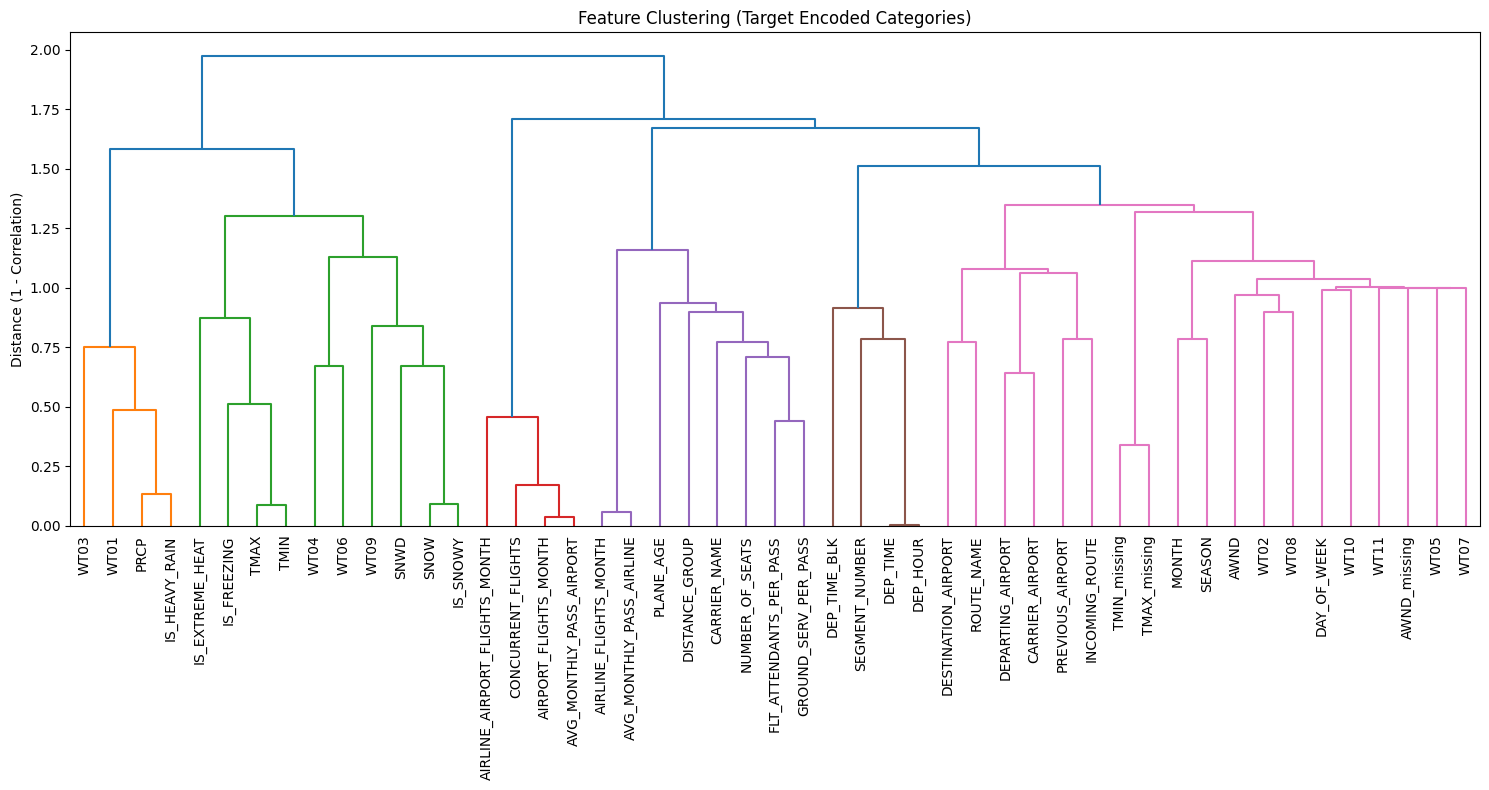

In [ ]:


# Now X_encoded is entirely numeric.
# We use Spearman because the relationship might be monotonic but not linear.
corr_matrix = X_encoded.corr(method='spearman').abs()

# Generate Distance Matrix
distance_matrix = 1 - corr_matrix
distance_matrix = np.clip(distance_matrix, 0, 1) # Ensure no floating point errors < 0

# Hierarchical Clustering
dist_linkage = sch.linkage(squareform(distance_matrix, checks=False), method='ward')

# Plot Dendrogram
plt.figure(figsize=(15, 8))
dendro = sch.dendrogram(
    dist_linkage,
    labels=X_encoded.columns,
    leaf_rotation=90,
    leaf_font_size=10
)
plt.title("Feature Clustering (Target Encoded Categories)")
plt.ylabel("Distance (1 - Correlation)")
plt.tight_layout()
plt.show()

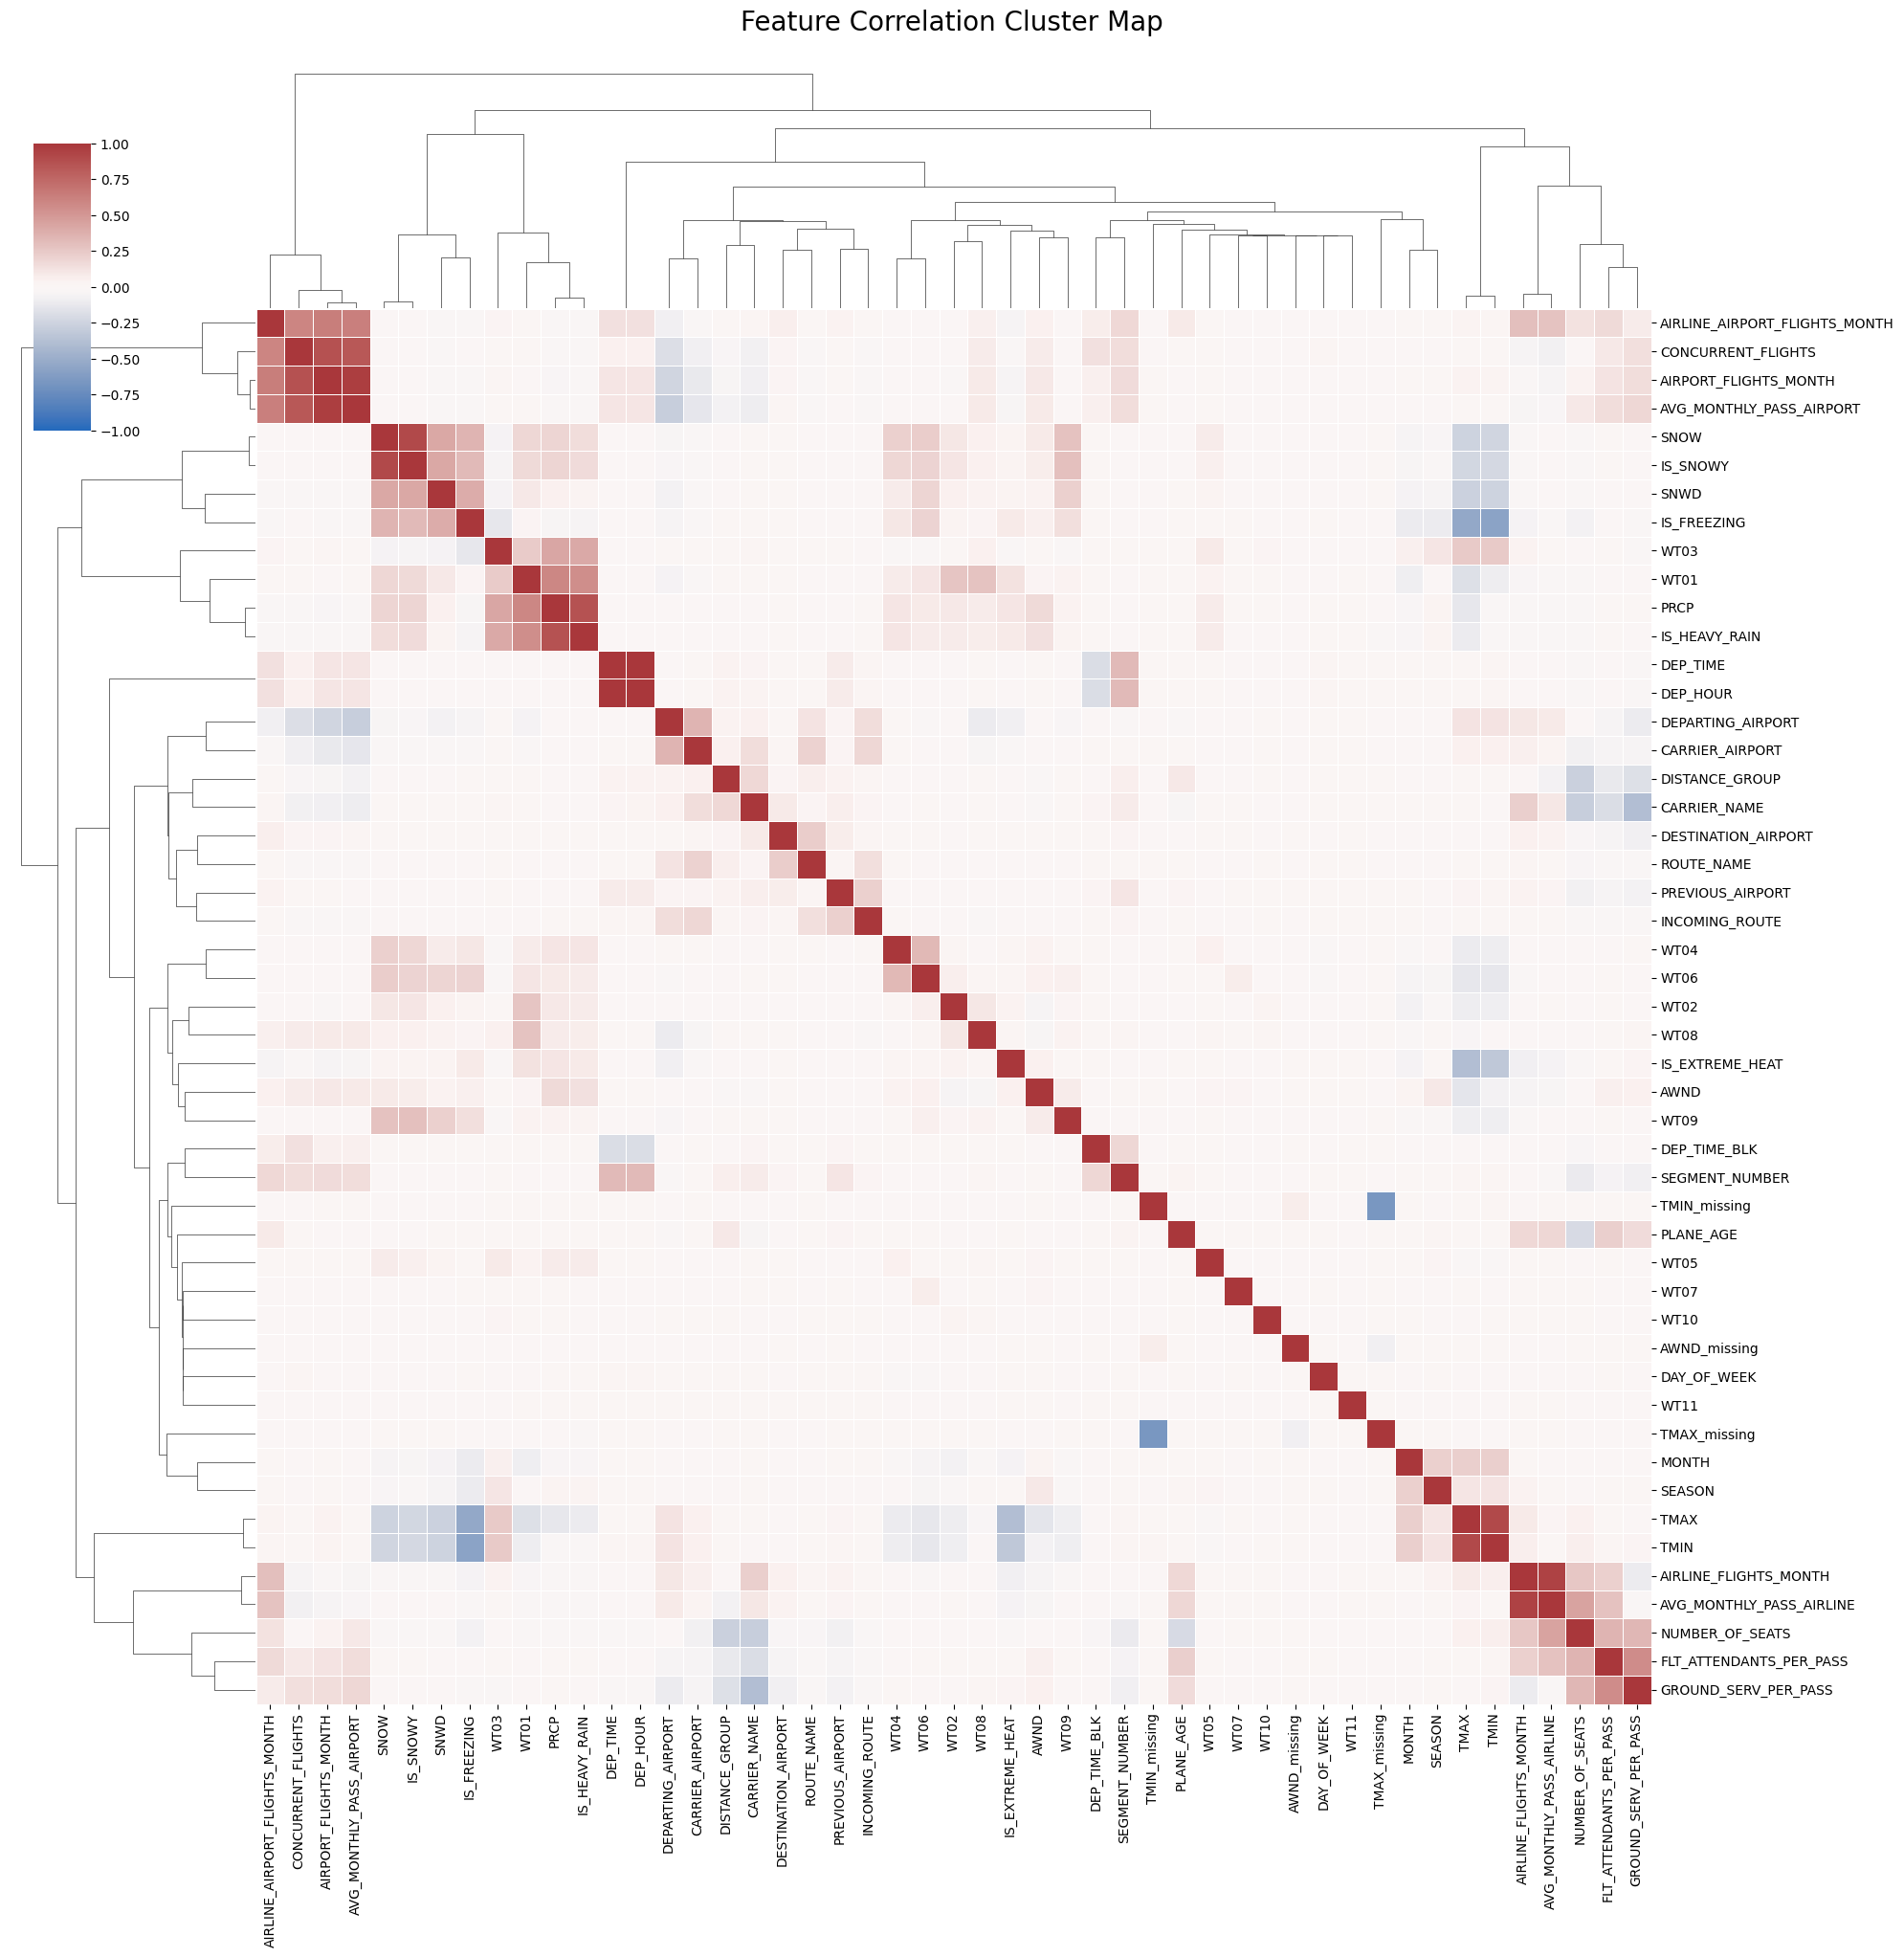

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- SETUP ---
# Ensure X_encoded is ready (Target Encoded categories + Numeric columns)
# If you need to re-run the correlation:
corr_matrix = X_encoded.corr(method='spearman')

# --- PLOTTING ---
# sns.clustermap does the heavy lifting:
# 1. Performs hierarchical clustering
# 2. Reorders your matrix to match the clusters
# 3. Plots the heatmap with the dendrograms attached

g = sns.clustermap(
    corr_matrix,
    method='ward',           # The same clustering method we used before
    cmap='vlag',             # 'vlag' or 'coolwarm' are standard for correlations
    center=0,                # Anchor 0 correlation to white/gray
    vmin=-1, vmax=1,         # Fix scale between -1 and 1
    linewidths=0.5,          # distinct grid lines
    figsize=(20, 20),        # Big size for readability
    dendrogram_ratio=(0.15, 0.15), # Proportion of figure used for the tree
    cbar_pos=(0.02, 0.8, 0.03, 0.15) # Position of color bar
)

# Adjust the rotation of the labels for readability
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

g.fig.suptitle('Feature Correlation Cluster Map', y=1.02, fontsize=20)
plt.show()

## Shapely Feature Importance

In [23]:
def get_group_name(features_in_group):
    """
    Scans the list of features in a cluster and assigns a human-readable name
    based on keywords. Returns a default name if no keywords match.
    """
    # Convert to set for faster lookups, and make uppercase for consistency
    feats_set = {f.upper() for f in features_in_group}

    # --- RULE SET (Customize this!) ---

    if 'CARRIER_NAME' in feats_set:
        return "Carrier Info"

    # Weather Rules
    if any('SNOW' in f for f in feats_set) or 'IS_SNOWY' in feats_set:
        return "Winter Weather"

    if any('PRCP' in f for f in feats_set) or 'WT03' in feats_set:
        return "Precipitation & Storms"

    if 'MONTH' in feats_set or 'SEASON' in feats_set:
        return "Seasonality"

    if 'TMAX' in feats_set or 'TMIN' in feats_set:
        return "Temperature Extremes"

    if 'DISTANCE_GROUP' in feats_set:
        return "Distance & Flight Capacity"
    if 'AIRPORT_FLIGHTS_MONTH' in feats_set:
        return "Airport Traffic Volume"

    if "AIRLINE_FLIGHTS_MONTH" in feats_set:
        return "Airline Scale"
    # Time Rules
    if 'DEP_TIME' in feats_set or 'DEP_HOUR' in feats_set:
        return "Time of Day"

    if 'DAY_OF_WEEK' in feats_set:
        return "Day of Week"

    if 'DEPARTING_AIRPORT' in feats_set or 'ROUTE_NAME' in feats_set:
        return "Origin & Route"
    if 'PREVIOUS_AIRPORT' in feats_set or 'INCOMING_ROUTE' in feats_set:
        return "Previous Airport Info"

    # Traffic / Airport Rules
    if any('CONCURRENT' in f for f in feats_set):
        return "Airport Traffic Volume"

    if 'DESTINATION_AIRPORT' in feats_set:
        return "Destination Airport"

    if 'PLANE_AGE' in feats_set:
        return "Plane Age"

    if 'AWND' in feats_set:
        return "Wind Speed"

    if 'FLT_ATTENDANTS_PER_PASS' in feats_set:
        return "Service:Passenger Ratios"

    if 'WT02' in feats_set:
        return 'Fog & Misc. Weather'

    # --- DEFAULT FALLBACK ---
    # If no rules match, use the "First Feature + Count" format
    return f"{features_in_group[0]} + {len(features_in_group)-1} others"

### Classifier

In [24]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import squareform

# --- 1. EXTRACT & TRANSFORM ---

# Extract the model and preprocessor objects
clf_preprocessor = clf_pipeline.preprocessor


# Transform X_test
# This fixes the "Categorical Mismatch" error by forcing test data
# into the exact numeric/encoded shape the model learned on.
X_test_transformed = clf_preprocessor.transform(X_test)

# Get Feature Names
# We need these to label the graph. Modern sklearn uses get_feature_names_out()
try:
    feature_names = clf_preprocessor.get_feature_names_out()
except AttributeError:
    # Fallback for older sklearn or custom transformers
    # If X_test_transformed is a DataFrame, use its columns
    if hasattr(X_test_transformed, 'columns'):
        feature_names = X_test_transformed.columns
    else:
        # Last resort: just index numbers
        feature_names = [f"Feature {i}" for i in range(X_test_transformed.shape[1])]

# Convert transformed data to DataFrame for easier handling
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

DROPPED FEATURES:
[]


#### Subsample with Stratification

In [25]:
from sklearn.model_selection import train_test_split
## Downsample so that the shap value calculations don't take hours
SAMPLE_SIZE = 10000
# 2. Use train_test_split to get a stratified sample
# We treat the "test_size" as the portion we WANT to keep.
# stratify=y_test ensures the ratio of 0s and 1s remains identical to the full set.
_, X_shap_sample, _, y_shap_sample = train_test_split(
    X_test_df,
    y_test_binary,
    test_size=SAMPLE_SIZE,
    stratify=y_test_binary,
    random_state= 42 # 38
)

print(f"Original Positive Ratio: {y_test_binary.mean():.4f}")
print(f"Sample Positive Ratio:   {y_shap_sample.mean():.4f}")
# These two numbers should be nearly identical.

Original Positive Ratio: 0.1724
Sample Positive Ratio:   0.1724


In [26]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import squareform

# Extract the model and preprocessor objects
preprocessor = clf_pipeline.preprocessor
model = clf_model

# --- 2. CLUSTERING (Identifying Redundant Groups) ---

# Create a copy for correlation analysis so we don't break the original data
X_for_corr = X_shap_sample.copy()

# A. Force-Convert Categoricals/Strings to Numbers
# We iterate through every column. If it's not a number, we turn it into one.
for col in X_for_corr.columns:
    if not pd.api.types.is_numeric_dtype(X_for_corr[col]):

        # If it's already a category dtype, use the underlying codes (0, 1, 2...)
        if isinstance(X_for_corr[col].dtype, pd.CategoricalDtype):
            X_for_corr[col] = X_for_corr[col].cat.codes

        # If it's a raw object/string, factorize it (assigns 0, 1, 2... to unique strings)
        else:
            X_for_corr[col] = pd.factorize(X_for_corr[col])[0]

# Ensure no NaNs or Infs remain after conversion, fill with 0 or mean if necessary
# For correlation, 0 is often a safe fill value for encoded categories.
X_for_corr = X_for_corr.fillna(0) # Or X_for_corr.mean()
X_for_corr = X_for_corr.replace([np.inf, -np.inf], 0) # Replace infinities

# B. Correlation
# Now X_for_corr is guaranteed to be all numbers
corr_matrix = X_for_corr.corr(method='spearman').abs()

# C. Clustering
distance_matrix = 1 - corr_matrix
# 2. Extract raw numpy array (removes potential index misalignment issues)
dist_array = distance_matrix.values
# 3. FIX: Handle NaNs (caused by constant columns)
# If a feature has 0 variance, corr is NaN. We treat this as "max distance" (1.0)
if np.isnan(dist_array).any():
    print("Warning: NaNs detected in correlation matrix (likely constant features). Filling with 1.0.")
    np.nan_to_num(dist_array, copy=False, nan=1.0)

# 4. FIX: Force Perfect Symmetry
# (A + A.T) / 2 ensures element [i,j] is mathematically identical to [j,i]
dist_array = (dist_array + dist_array.T) / 2.0

# 5. FIX: Force Diagonal to Exactly Zero
# Floating point math might result in 1e-16 instead of 0. This fixes it.
np.fill_diagonal(dist_array, 0.0)

dist_linkage = linkage(squareform(dist_array), method='ward')

# D. Create Groups
THRESHOLD = 0.75
cluster_labels = fcluster(dist_linkage, t=THRESHOLD, criterion='distance')

cluster_map = {}
for feat_idx, cluster_id in enumerate(cluster_labels):
    feat_name = feature_names[feat_idx]
    if cluster_id not in cluster_map:
        cluster_map[cluster_id] = []
    cluster_map[cluster_id].append(feat_name)

print("Clustering complete. Proceed to Step 3 (SHAP Calculation).")

Clustering complete. Proceed to Step 3 (SHAP Calculation).


In [27]:
cluster_map

{np.int32(1): ['MONTH', 'TMAX', 'TMIN', 'SEASON'],
 np.int32(23): ['DAY_OF_WEEK'],
 np.int32(6): ['DEP_TIME', 'DEP_TIME_BLK', 'DEP_HOUR', 'SEGMENT_NUMBER'],
 np.int32(10): ['DISTANCE_GROUP', 'NUMBER_OF_SEATS'],
 np.int32(8): ['CONCURRENT_FLIGHTS',
  'AIRPORT_FLIGHTS_MONTH',
  'AIRLINE_AIRPORT_FLIGHTS_MONTH',
  'AVG_MONTHLY_PASS_AIRPORT'],
 np.int32(12): ['CARRIER_NAME', 'CARRIER_AIRPORT'],
 np.int32(13): ['AIRLINE_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRLINE'],
 np.int32(9): ['FLT_ATTENDANTS_PER_PASS', 'GROUND_SERV_PER_PASS'],
 np.int32(11): ['PLANE_AGE'],
 np.int32(7): ['DEPARTING_AIRPORT', 'ROUTE_NAME'],
 np.int32(15): ['PREVIOUS_AIRPORT', 'INCOMING_ROUTE'],
 np.int32(16): ['DESTINATION_AIRPORT'],
 np.int32(14): ['PRCP', 'WT01', 'WT03', 'IS_HEAVY_RAIN'],
 np.int32(4): ['SNOW', 'SNWD', 'IS_SNOWY', 'IS_FREEZING'],
 np.int32(25): ['AWND'],
 np.int32(17): ['WT02'],
 np.int32(3): ['WT04', 'WT06'],
 np.int32(27): ['WT05'],
 np.int32(26): ['WT07'],
 np.int32(18): ['WT08'],
 np.int32(5): ['WT09

#### Compute and Plot

In [ ]:
# --- 3. SHAP CALCULATION ---
from tqdm.auto import tqdm

# Settings
BATCH_SIZE = 1000  # Process 1000 rows at a time
shap_batches = []
X_test_batches = np.array_split(X_shap_sample, np.ceil(len(X_shap_sample) / BATCH_SIZE))

explainer = shap.TreeExplainer(clf_model)

print(f"Starting SHAP calculation on {len(X_shap_sample)} rows...")

# Loop with progress bar
for batch in tqdm(X_test_batches, desc="Calculating SHAP"):
    # Calculate SHAP for this chunk
    batch_shap = explainer.shap_values(batch)

    # Handle list output (binary classification)
    if isinstance(batch_shap, list):
        batch_shap = batch_shap[1]

    shap_batches.append(batch_shap)

# Combine back into one big array
shap_values_raw_clf = np.concatenate(shap_batches, axis=0)

print("Calculation Complete.")

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Starting SHAP calculation on 10000 rows...


Calculating SHAP:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local

##### Random State 42

/tmp/ipython-input-88892246.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')


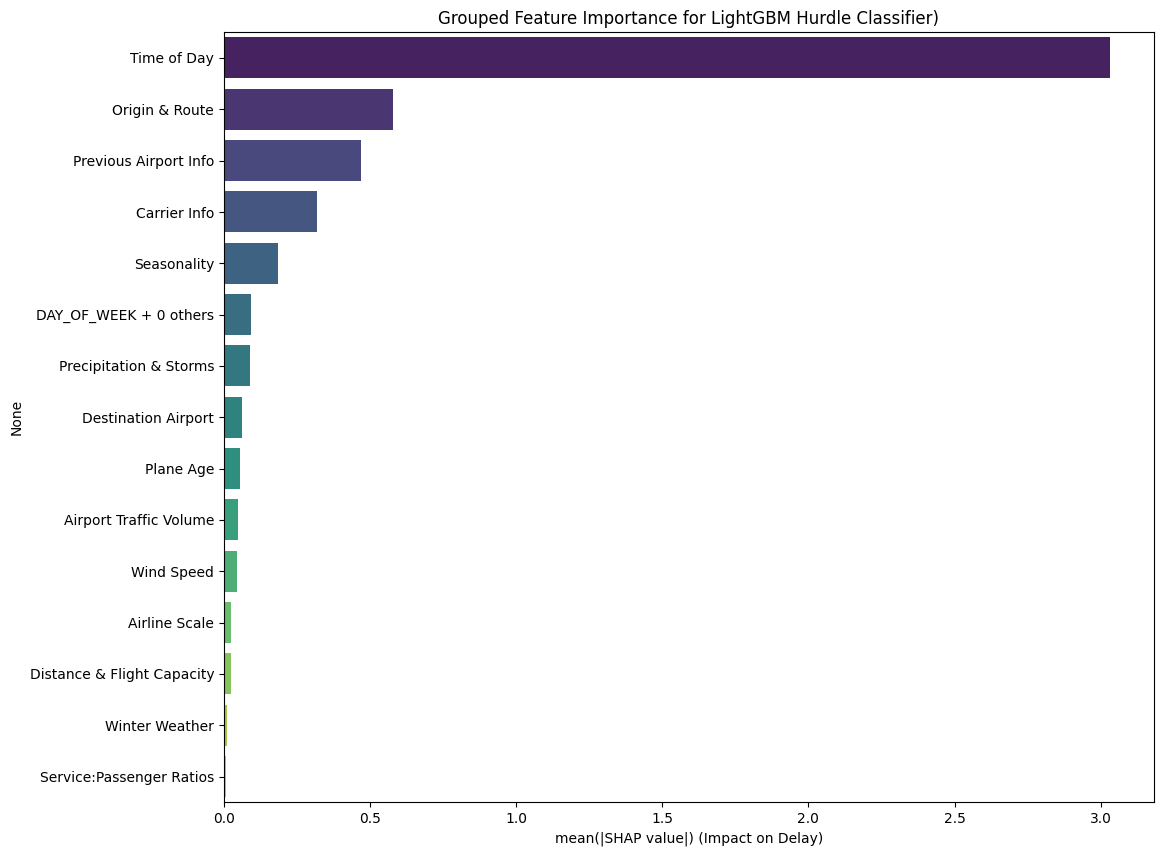


--- Top Group Compositions ---
[Time of Day] contains: ['DEP_TIME', 'DEP_TIME_BLK', 'DEP_HOUR', 'SEGMENT_NUMBER']
[Origin & Route] contains: ['DEPARTING_AIRPORT', 'ROUTE_NAME']
[Previous Airport Info] contains: ['PREVIOUS_AIRPORT', 'INCOMING_ROUTE']
[Carrier Info] contains: ['CARRIER_NAME', 'CARRIER_AIRPORT']
[Seasonality] contains: ['MONTH', 'TMAX', 'TMIN', 'SEASON']
[DAY_OF_WEEK + 0 others] contains: ['DAY_OF_WEEK']
[Precipitation & Storms] contains: ['PRCP', 'WT01', 'WT03', 'IS_HEAVY_RAIN']
[Destination Airport] contains: ['DESTINATION_AIRPORT']
[Plane Age] contains: ['PLANE_AGE']
[Airport Traffic Volume] contains: ['CONCURRENT_FLIGHTS', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT']
[Wind Speed] contains: ['AWND']
[Airline Scale] contains: ['AIRLINE_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRLINE']
[Distance & Flight Capacity] contains: ['DISTANCE_GROUP', 'NUMBER_OF_SEATS']
[Winter Weather] contains: ['SNOW', 'SNWD', 'IS_SNOWY', 'IS_FREEZING']
[Ser

In [ ]:
# Create DataFrame
shap_df = pd.DataFrame(shap_values_raw_clf, columns=feature_names)

# AGGREGATE SHAP BY GROUP
grouped_shap_df = pd.DataFrame()
group_definitions = {} # To store what's inside each group for reference

# Iterate through the clusters we found earlier
for cid, feats in cluster_map.items():

    # A. Sum the SHAP values for all features in this group
    total_impact = shap_df[feats].sum(axis=1)

    # B. Generate the Smart Name using your function
    final_name = get_group_name(feats)

    # C. Handle Duplicate Names
    # (Rare edge case: if two different clusters both map to "Winter Weather",
    # we append the ID to distinguish them)
    if final_name in grouped_shap_df.columns:
        final_name = f"{final_name} (Grp {cid})"

    # D. Store results
    grouped_shap_df[final_name] = total_impact
    group_definitions[final_name] = feats
# --- 5. PLOTTING ---
plt.figure(figsize=(12, 10))

# Sort by mean absolute impact
mean_shap = np.abs(grouped_shap_df).mean().sort_values(ascending=False)
top_n = mean_shap.head(15) # Show top 25 groups

sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')
plt.title(f'Grouped Feature Importance for LightGBM Hurdle Classifier)')
plt.xlabel('mean(|SHAP value|) (Impact on Delay)')
plt.show()

# --- 6. INSPECT THE GROUPS ---
print("\n--- Top Group Compositions ---")
for name in top_n.index:
    print(f"[{name}] contains: {group_definitions[name]}")

##### Random State 38

/tmp/ipython-input-2494468104.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')


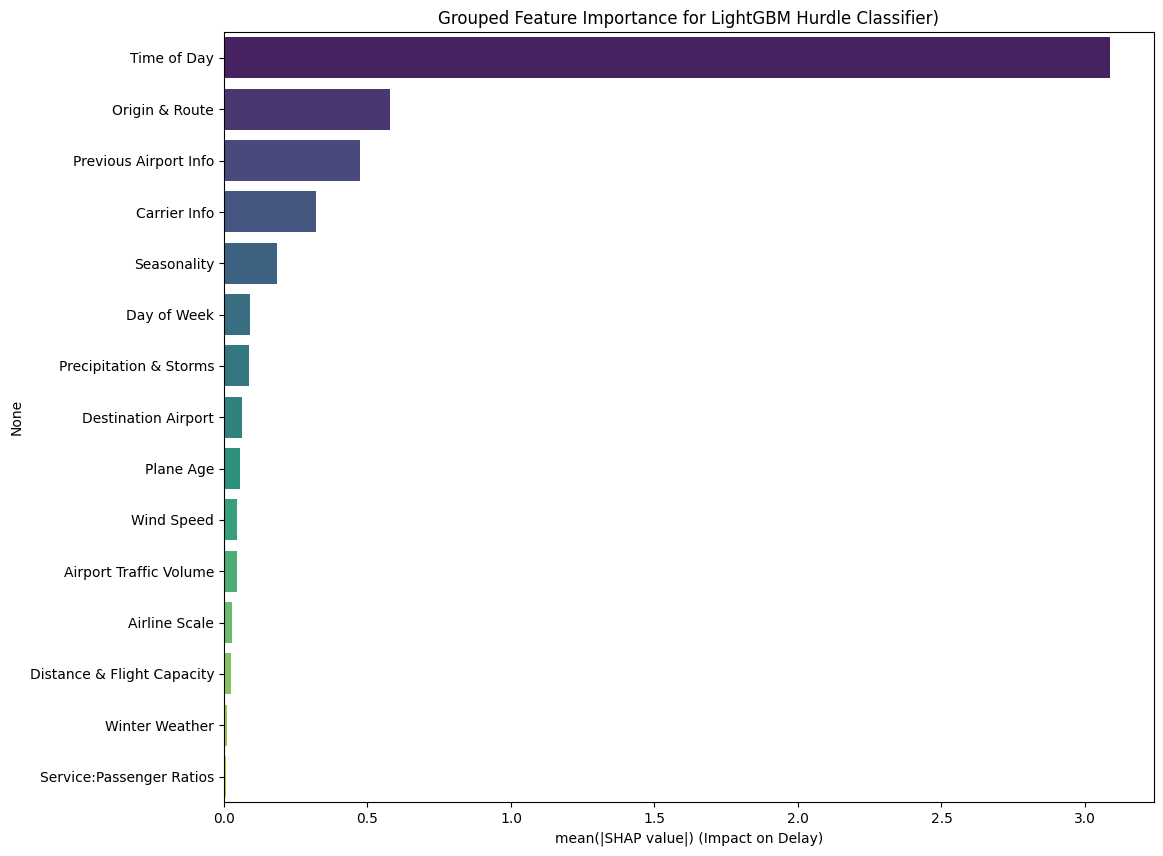


--- Top Group Compositions ---
[Time of Day] contains: ['DEP_TIME', 'DEP_TIME_BLK', 'DEP_HOUR', 'SEGMENT_NUMBER']
[Origin & Route] contains: ['DEPARTING_AIRPORT', 'ROUTE_NAME']
[Previous Airport Info] contains: ['PREVIOUS_AIRPORT', 'INCOMING_ROUTE']
[Carrier Info] contains: ['CARRIER_NAME', 'CARRIER_AIRPORT']
[Seasonality] contains: ['MONTH', 'TMAX', 'TMIN', 'IS_FREEZING', 'SEASON']
[Day of Week] contains: ['DAY_OF_WEEK']
[Precipitation & Storms] contains: ['PRCP', 'WT01', 'WT03', 'IS_HEAVY_RAIN']
[Destination Airport] contains: ['DESTINATION_AIRPORT']
[Plane Age] contains: ['PLANE_AGE']
[Wind Speed] contains: ['AWND']
[Airport Traffic Volume] contains: ['CONCURRENT_FLIGHTS', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT']
[Airline Scale] contains: ['AIRLINE_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRLINE']
[Distance & Flight Capacity] contains: ['DISTANCE_GROUP', 'NUMBER_OF_SEATS']
[Winter Weather] contains: ['SNOW', 'SNWD', 'IS_SNOWY']
[Service:Passen

In [ ]:
# Create DataFrame
shap_df = pd.DataFrame(shap_values_raw_clf, columns=feature_names)

# AGGREGATE SHAP BY GROUP
grouped_shap_df = pd.DataFrame()
group_definitions = {} # To store what's inside each group for reference

# Iterate through the clusters we found earlier
for cid, feats in cluster_map.items():

    # A. Sum the SHAP values for all features in this group
    total_impact = shap_df[feats].sum(axis=1)

    # B. Generate the Smart Name using your function
    final_name = get_group_name(feats)

    # C. Handle Duplicate Names
    # (Rare edge case: if two different clusters both map to "Winter Weather",
    # we append the ID to distinguish them)
    if final_name in grouped_shap_df.columns:
        final_name = f"{final_name} (Grp {cid})"

    # D. Store results
    grouped_shap_df[final_name] = total_impact
    group_definitions[final_name] = feats
# --- 5. PLOTTING ---
plt.figure(figsize=(12, 10))

# Sort by mean absolute impact
mean_shap = np.abs(grouped_shap_df).mean().sort_values(ascending=False)
top_n = mean_shap.head(15) # Show top 25 groups

sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')
plt.title(f'Grouped Feature Importance for LightGBM Hurdle Classifier)')
plt.xlabel('mean(|SHAP value|) (Impact on Delay)')
plt.show()

# --- 6. INSPECT THE GROUPS ---
print("\n--- Top Group Compositions ---")
for name in top_n.index:
    print(f"[{name}] contains: {group_definitions[name]}")

### Hurdle Regressor

#### Stratify with close as possible stratification

In [ ]:
# Extract Regressor Pipeline components
# (Ensure 'reg_pipeline' is the correct variable name for your Gamma Regressor)
reg_preprocessor = reg_pipeline.preprocessor
model = reg_model

# --- 2. FILTER FOR POSITIVES ONLY ---
# Filter X_test and y_test to only include flights that were actually delayed
positive_mask = y_test_reg > 0
X_test_positives = X_test.loc[positive_mask].copy()

# IMPORTANT: We need the continuous target (Magnitude) for stratification,
# not the binary class. Let's assume you have 'y_test_mags' available
# (the actual delay minutes for the test set).
y_test_mags_positives = y_test_reg.loc[positive_mask].copy()

print(f"Regressor Domain (Positives Only): {len(X_test_positives)}")
# Transform X_test
# This fixes the "Categorical Mismatch" error by forcing test data
# into the exact numeric/encoded shape the model learned on.

X_test_positives_transformed = reg_preprocessor.transform(X_test_positives)

# Get Feature Names
# We need these to label the graph. Modern sklearn uses get_feature_names_out()
try:
    feature_names = reg_preprocessor.get_feature_names_out()
except AttributeError:
    # Fallback for older sklearn or custom transformers
    # If X_test_transformed is a DataFrame, use its columns
    if hasattr(X_test_positives_transformed, 'columns'):
        feature_names = X_test_positives_transformed.columns
    else:
        # Last resort: just index numbers
        feature_names = [f"Feature {i}" for i in range(X_test_positives_transformed.shape[1])]

Regressor Domain (Positives Only): 219257


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [ ]:
from sklearn.model_selection import train_test_split

# --- 1. DEFINE YOUR HELPER FUNCTION ---
def stratify_continuous_target(y, n_bins=10):
    """
    Creates discrete bins for stratifying.
    Adapted logic: Since we will only pass positive values,
    Bin 0 (Zeros) will effectively be unused, and we will get Bins 1-10.
    """
    # Ensure input is numpy array for indexing
    y = np.array(y)

    # Initialize (default to 1 instead of 0 since we assume all are positive here)
    bins = np.ones_like(y, dtype=int)

    # 2. Identify Positive Examples (Should be all of them in this step)
    mask_pos = y > 0
    y_pos = y[mask_pos]

    if len(y_pos) > 0:
        # 3. Bin the positive tail into quantiles
        try:
            # duplicates='drop' is safer for sparse data
            pos_bins = pd.qcut(y_pos, q=n_bins, labels=False, duplicates='drop') + 1
            bins[mask_pos] = pos_bins
        except ValueError:
            pass # Keep default bin 1

    return bins

# --- 3. CREATE STRATIFICATION BINS ---
# This creates bins 1-10 based on the MAGNITUDE of the delay
strat_bins = stratify_continuous_target(y_test_mags_positives, n_bins=10)

print(f"Stratification Bins Created: {np.unique(strat_bins)}")

# --- 4. STRATIFIED DOWNSAMPLE ---
SAMPLE_SIZE = 10000

if len(X_test_positives) > SAMPLE_SIZE:
    # We stratify on 'strat_bins' to preserve the distribution of delay severities
    _, X_shap_sample, _, _ = train_test_split(
        X_test_positives,
        strat_bins,  # Stratify by Delay Magnitude Bin
        test_size=SAMPLE_SIZE,
        stratify=strat_bins,
        random_state= 38# 42
    )
else:
    X_shap_sample = X_test_positives



# Transform sample
X_sample_positives_transformed = reg_preprocessor.transform(X_shap_sample)

# Get feature names
try:
    feature_names = reg_preprocessor.get_feature_names_out()
except AttributeError:
    if hasattr(X_sample_positives_transformed, 'columns'):
        feature_names = X_sample_positives_transformed.columns
    else:
        feature_names = [f"Feature {i}" for i in range(X_sample_positives_transformed.shape[1])]

# Convert transformed data to DataFrame for easier handling
X_sample_pos_df = pd.DataFrame(X_sample_positives_transformed, columns=feature_names)

print(f"Sample Ready for SHAP. Shape: {X_sample_pos_df.shape}")

Stratification Bins Created: [ 1  2  3  4  5  6  7  8  9 10]
Sample Ready for SHAP. Shape: (10000, 49)


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [ ]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import squareform

# --- 2. CLUSTERING (Identifying Redundant Groups) ---

# Create a copy for correlation analysis so we don't break the original data
X_for_corr = X_sample_pos_df.copy()

# A. Force-Convert Categoricals/Strings to Numbers
# We iterate through every column. If it's not a number, we turn it into one.
for col in X_for_corr.columns:
    if not pd.api.types.is_numeric_dtype(X_for_corr[col]):

        # If it's already a category dtype, use the underlying codes (0, 1, 2...)
        if isinstance(X_for_corr[col].dtype, pd.CategoricalDtype):
            X_for_corr[col] = X_for_corr[col].cat.codes

        # If it's a raw object/string, factorize it (assigns 0, 1, 2... to unique strings)
        else:
            X_for_corr[col] = pd.factorize(X_for_corr[col])[0]

# Ensure no NaNs or Infs remain after conversion, fill with 0 or mean if necessary
# For correlation, 0 is often a safe fill value for encoded categories.
X_for_corr = X_for_corr.fillna(0) # Or X_for_corr.mean()
X_for_corr = X_for_corr.replace([np.inf, -np.inf], 0) # Replace infinities

# B. Correlation
# Now X_for_corr is guaranteed to be all numbers
corr_matrix = X_for_corr.corr(method='spearman').abs()

# C. Clustering
distance_matrix = 1 - corr_matrix
# 2. Extract raw numpy array (removes potential index misalignment issues)
dist_array = distance_matrix.values
# 3. FIX: Handle NaNs (caused by constant columns)
# If a feature has 0 variance, corr is NaN. We treat this as "max distance" (1.0)
if np.isnan(dist_array).any():
    print("Warning: NaNs detected in correlation matrix (likely constant features). Filling with 1.0.")
    np.nan_to_num(dist_array, copy=False, nan=1.0)

# 4. FIX: Force Perfect Symmetry
# (A + A.T) / 2 ensures element [i,j] is mathematically identical to [j,i]
dist_array = (dist_array + dist_array.T) / 2.0

# 5. FIX: Force Diagonal to Exactly Zero
# Floating point math might result in 1e-16 instead of 0. This fixes it.
np.fill_diagonal(dist_array, 0.0)

dist_linkage = linkage(squareform(dist_array), method='ward')

# D. Create Groups
THRESHOLD = 0.75
cluster_labels = fcluster(dist_linkage, t=THRESHOLD, criterion='distance')

cluster_map = {}
for feat_idx, cluster_id in enumerate(cluster_labels):
    feat_name = feature_names[feat_idx]
    if cluster_id not in cluster_map:
        cluster_map[cluster_id] = []
    cluster_map[cluster_id].append(feat_name)

print("Clustering complete. Proceed to Step 3 (SHAP Calculation).")

Clustering complete. Proceed to Step 3 (SHAP Calculation).


In [ ]:
cluster_map

{np.int32(1): ['MONTH', 'TMAX', 'TMIN', 'SEASON'],
 np.int32(16): ['DAY_OF_WEEK'],
 np.int32(18): ['DEP_TIME', 'DEP_TIME_BLK', 'DEP_HOUR', 'SEGMENT_NUMBER'],
 np.int32(22): ['DISTANCE_GROUP', 'NUMBER_OF_SEATS'],
 np.int32(20): ['CONCURRENT_FLIGHTS',
  'AIRPORT_FLIGHTS_MONTH',
  'AIRLINE_AIRPORT_FLIGHTS_MONTH',
  'AVG_MONTHLY_PASS_AIRPORT'],
 np.int32(24): ['CARRIER_NAME', 'CARRIER_AIRPORT'],
 np.int32(25): ['AIRLINE_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRLINE'],
 np.int32(21): ['FLT_ATTENDANTS_PER_PASS', 'GROUND_SERV_PER_PASS'],
 np.int32(23): ['PLANE_AGE'],
 np.int32(19): ['DEPARTING_AIRPORT', 'ROUTE_NAME'],
 np.int32(8): ['PREVIOUS_AIRPORT', 'INCOMING_ROUTE'],
 np.int32(9): ['DESTINATION_AIRPORT'],
 np.int32(7): ['PRCP', 'WT01', 'WT03', 'IS_HEAVY_RAIN'],
 np.int32(4): ['SNOW', 'SNWD', 'IS_SNOWY', 'IS_FREEZING'],
 np.int32(13): ['AWND'],
 np.int32(10): ['WT02'],
 np.int32(3): ['WT04', 'WT06'],
 np.int32(15): ['WT05'],
 np.int32(14): ['WT07'],
 np.int32(11): ['WT08'],
 np.int32(5): ['WT0

#### Compute and Plot

In [ ]:
# --- 3. SHAP CALCULATION ---
from tqdm.auto import tqdm

# Settings
BATCH_SIZE = 1000  # Process 1000 rows at a time
shap_batches = []
X_test_batches = np.array_split(X_sample_pos_df, np.ceil(len(X_sample_pos_df) / BATCH_SIZE))

explainer = shap.TreeExplainer(reg_model)

print(f"Starting SHAP calculation on {len(X_sample_pos_df)} rows...")

# Loop with progress bar
for batch in tqdm(X_test_batches, desc="Calculating SHAP"):
    # Calculate SHAP for this chunk
    batch_shap = explainer.shap_values(batch)

    # Handle list output (binary classification)
    if isinstance(batch_shap, list):
        batch_shap = batch_shap[1]

    shap_batches.append(batch_shap)

# Combine back into one big array
shap_values_raw_reg = np.concatenate(shap_batches, axis=0)

print("Calculation Complete.")

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Starting SHAP calculation on 10000 rows...


Calculating SHAP:   0%|          | 0/10 [00:00<?, ?it/s]

Calculation Complete.


/tmp/ipython-input-468542937.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')


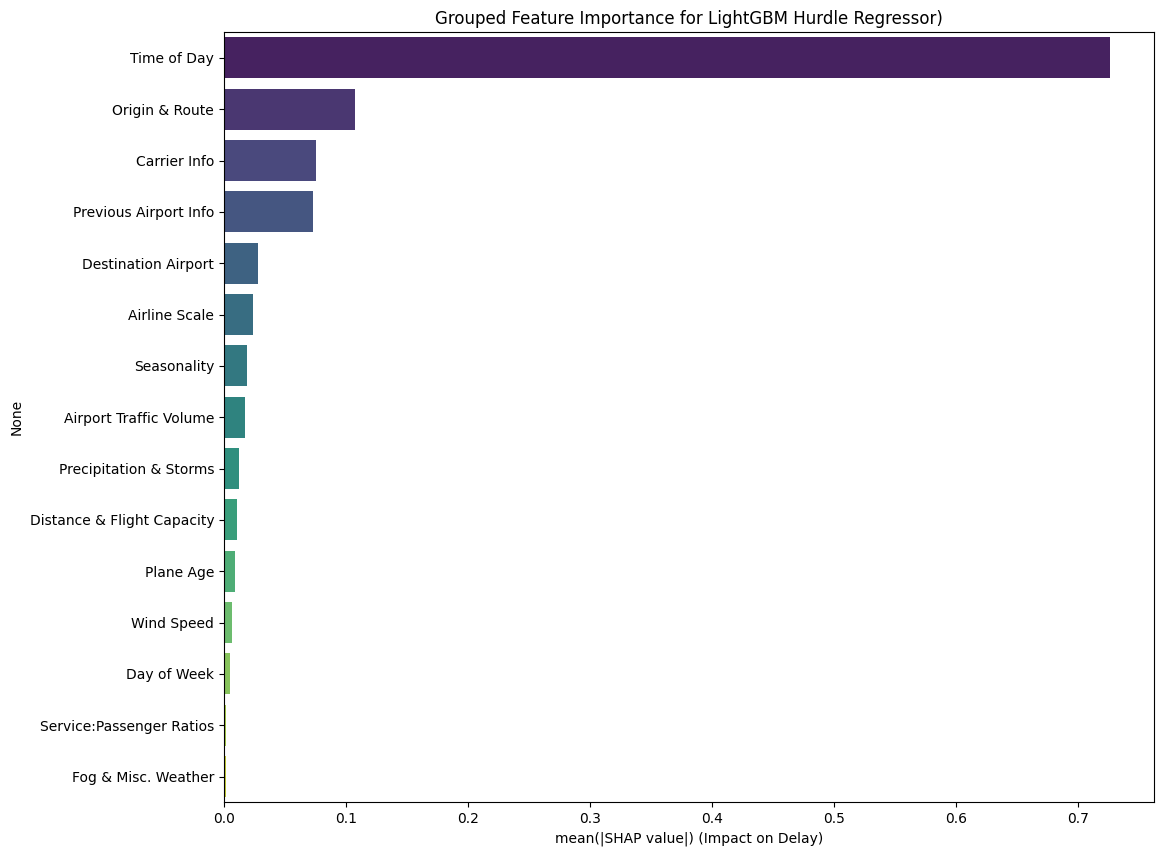


--- Top Group Compositions ---
[Time of Day] contains: ['DEP_TIME', 'DEP_TIME_BLK', 'DEP_HOUR', 'SEGMENT_NUMBER']
[Origin & Route] contains: ['DEPARTING_AIRPORT', 'ROUTE_NAME']
[Carrier Info] contains: ['CARRIER_NAME', 'CARRIER_AIRPORT']
[Previous Airport Info] contains: ['PREVIOUS_AIRPORT', 'INCOMING_ROUTE']
[Destination Airport] contains: ['DESTINATION_AIRPORT']
[Airline Scale] contains: ['AIRLINE_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRLINE']
[Seasonality] contains: ['MONTH', 'TMAX', 'TMIN', 'SEASON']
[Airport Traffic Volume] contains: ['CONCURRENT_FLIGHTS', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT']
[Precipitation & Storms] contains: ['PRCP', 'WT01', 'WT03', 'IS_HEAVY_RAIN']
[Distance & Flight Capacity] contains: ['DISTANCE_GROUP', 'NUMBER_OF_SEATS']
[Plane Age] contains: ['PLANE_AGE']
[Wind Speed] contains: ['AWND']
[Day of Week] contains: ['DAY_OF_WEEK']
[Service:Passenger Ratios] contains: ['FLT_ATTENDANTS_PER_PASS', 'GROUND_SERV_PER_PASS

In [ ]:
# Create DataFrame
shap_df = pd.DataFrame(shap_values_raw_reg, columns=feature_names)

# AGGREGATE SHAP BY GROUP
grouped_shap_df = pd.DataFrame()
group_definitions = {} # To store what's inside each group for reference

# Iterate through the clusters we found earlier
for cid, feats in cluster_map.items():

    # A. Sum the SHAP values for all features in this group
    total_impact = shap_df[feats].sum(axis=1)

    # B. Generate the Smart Name using your function
    final_name = get_group_name(feats)

    # C. Handle Duplicate Names
    # (Rare edge case: if two different clusters both map to "Winter Weather",
    # we append the ID to distinguish them)
    if final_name in grouped_shap_df.columns:
        final_name = f"{final_name} (Grp {cid})"

    # D. Store results
    grouped_shap_df[final_name] = total_impact
    group_definitions[final_name] = feats
# --- 5. PLOTTING ---
plt.figure(figsize=(12, 10))

# Sort by mean absolute impact
mean_shap = np.abs(grouped_shap_df).mean().sort_values(ascending=False)
top_n = mean_shap.head(15) # Show top 25 groups

sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')
plt.title(f'Grouped Feature Importance for LightGBM Hurdle Regressor)')
plt.xlabel('mean(|SHAP value|) (Impact on Delay)')
plt.show()

# --- 6. INSPECT THE GROUPS ---
print("\n--- Top Group Compositions ---")
for name in top_n.index:
    print(f"[{name}] contains: {group_definitions[name]}")